# Output File Analysis - Multiple SRRs - Donor to Recipient Workflows

This notebooks analyses the crossing of reads between a Human and a Donor, looking for putative insertions. When mapping thousands of reads, one would expect to find the reads to fall on a rolling window over the putative read that should look like what we see below.

Donor: https://www.ncbi.nlm.nih.gov/nuccore/M19503.1?report=fasta Recipient: https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/

Papers: 
- https://pubmed.ncbi.nlm.nih.gov/30552977
- https://pubmed.ncbi.nlm.nih.gov/30552977
- https://www.medrxiv.org/content/10.1101/2020.07.30.20165241v1

Data: 
- https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE91065
- https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE91065
- https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE150316

## Variables

For convenience, there might be more than one set of samples in the cells below. If so, note that the order matters, and only the last cell will be relevant, as the previous ones will be overwritten

In [33]:
## Variables
srr_names <- c(#HPV16 samples
               "SRR5090597", "SRR5090599", "SRR5090601", "SRR5090603",
               "SRR5090605", "SRR5090607", "SRR5090609", "SRR5090611",
               "SRR5090613", "SRR5090615", "SRR5090617", "SRR5090619",
               #HPV18 samples
               "SRR5090623", "SRR5090625", "SRR5090627", "SRR5090629", 
               "SRR5090631", "SRR5090633", "SRR5090635", "SRR5090637", 
               "SRR5090639", "SRR5090641",
               #HIV1 samples
               "SRR1106189", "SRR1106190", "SRR1106191", "SRR1106192", 
               "SRR1106193", "SRR1106194", "SRR1106195", "SRR1106196", 
               "SRR1106197", "SRR1106198", "SRR1106199", "SRR1106200", 
               "SRR1106201", "SRR1106203", "SRR1106204",
               #SARS-COV-2 samples
               "SRR11772358", "SRR11772359", "SRR11772360", "SRR11772361", 
               "SRR11772362", "SRR11772363", "SRR11772364", "SRR11772365", 
               "SRR11772366", "SRR11772367", "SRR11772368", "SRR11772369", 
               "SRR11772370", "SRR11772371", "SRR11772372", "SRR11772373", 
               "SRR11772374", "SRR11772375", "SRR11772376", "SRR11772377", 
               "SRR11772378", "SRR11772379", "SRR11772380", "SRR11772381", 
               "SRR11772382", "SRR11772383", "SRR11772384", "SRR11772385", 
               "SRR11772386", "SRR11772387", "SRR11772388", "SRR11772389", 
               "SRR11772390", "SRR11772391", "SRR11772392", "SRR11772393", 
               "SRR11772394", "SRR12340057", "SRR12340058", "SRR12340059", 
               "SRR12340060", "SRR12340061", "SRR12340062", "SRR12340063", 
               "SRR12340064", "SRR12340065", "SRR12340066", "SRR12340067", 
               "SRR12340068", "SRR12340069", "SRR12340070", "SRR12340071", 
               "SRR12340072", "SRR12340073", "SRR12340074", "SRR12340075", 
               "SRR12340076", "SRR12340077", "SRR12340078", "SRR12340079", 
               "SRR12340080", "SRR12340081", "SRR12340082", "SRR12340083", 
               "SRR12340084", "SRR12340085", "SRR12340086", "SRR12340087", 
               "SRR12340088", "SRR12340089", "SRR12340090", "SRR12340091", 
               "SRR12340092", "SRR12340093", "SRR12340094", "SRR12340095", 
               "SRR12340096", "SRR12340097", "SRR12340098", "SRR12340099", 
               "SRR12340100", "SRR12340101", "SRR12340102", "SRR12340103", 
               "SRR12340104", "SRR12340105", "SRR12340106", "SRR12340107"
               )
donor_name <- "line1"
recipient_name <- "UCSChg38"
inputs_folder <- "../../wallaby/workflows/outputs/line1_rnaseq"
donor_ref_genome <- "../../wallaby/data/ref_genomes/line1/LINE1.fa"
recipient_ref_genome <- "../../wallaby/data/ref_genomes/human/hg38.fa"

## Setup Environment

In [30]:
# Source external functions
source("srrs_util.R")

In [3]:
# Load libraries and setup multithreading
setup_enviroment()

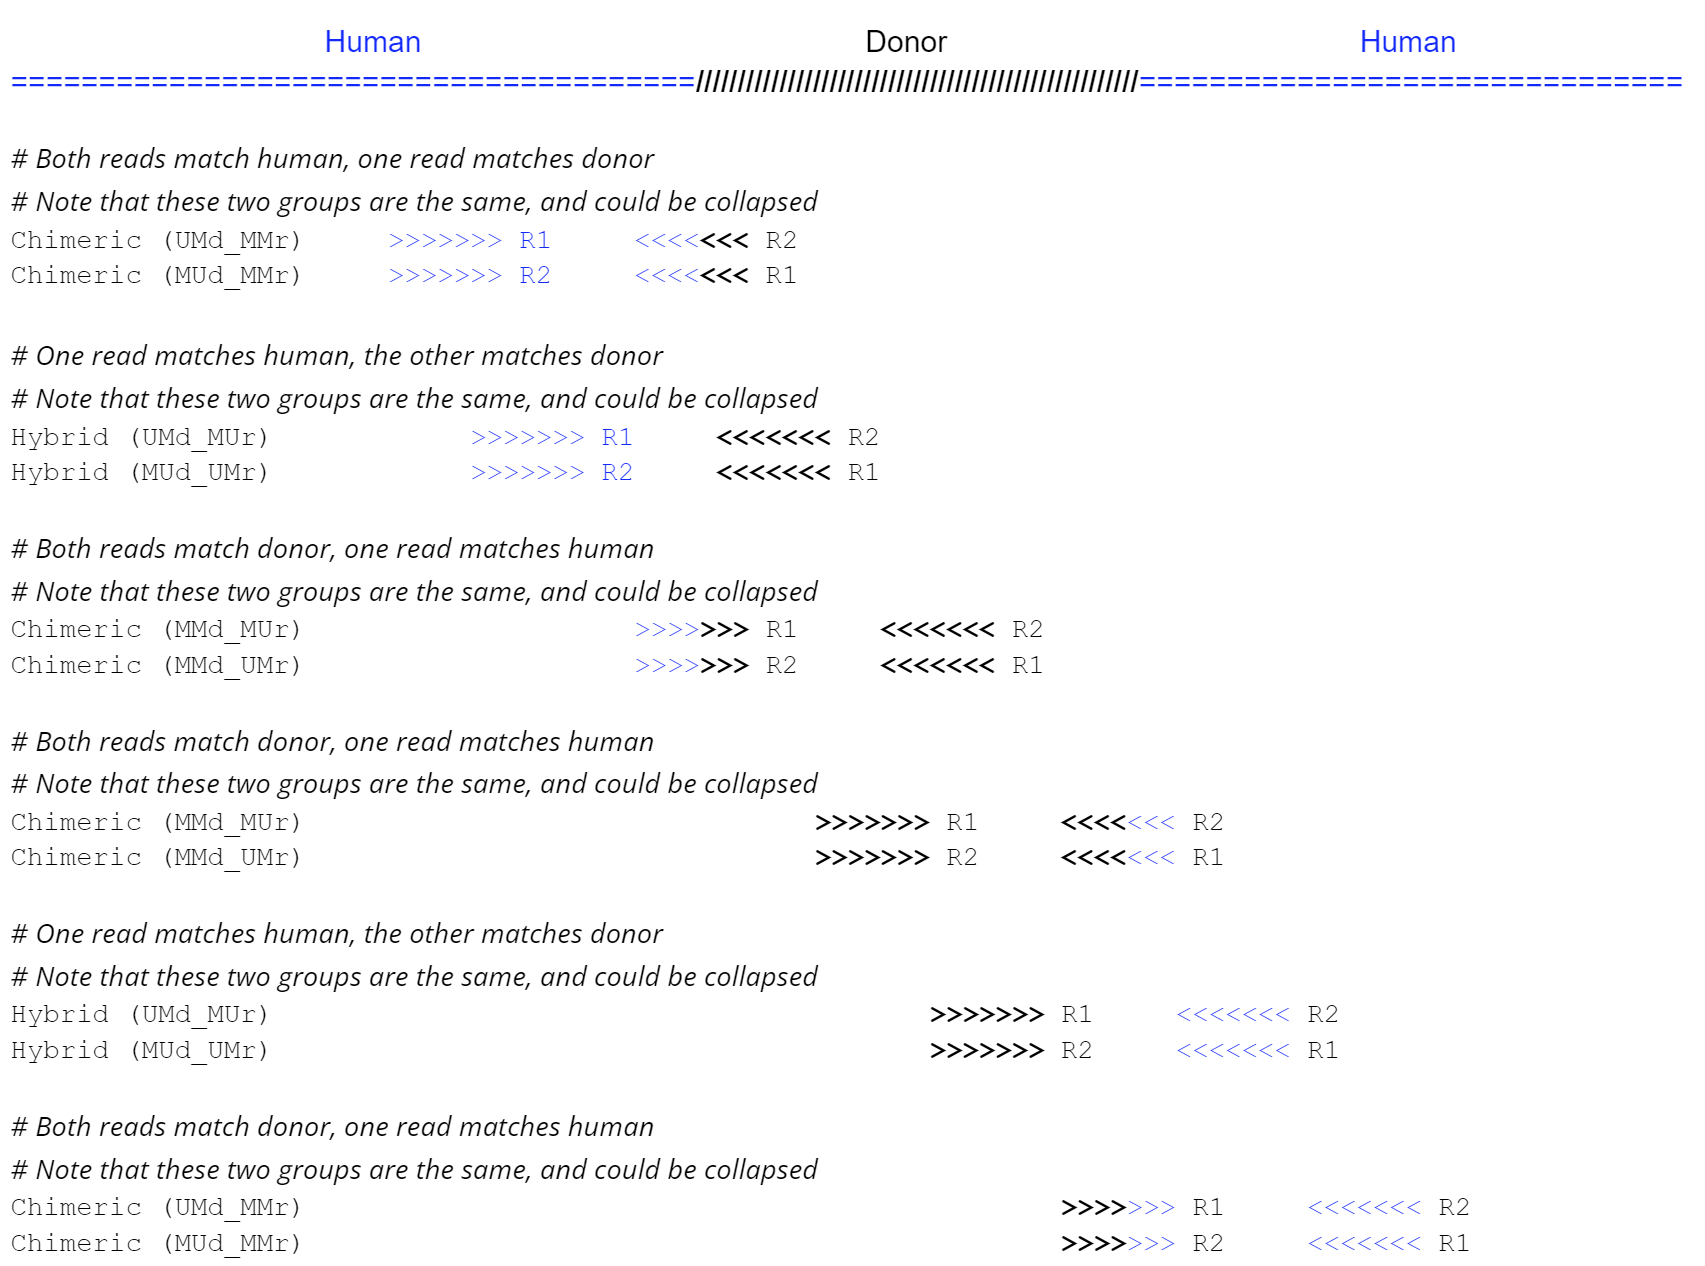

In [4]:
# Display rolling window diagram
display_png(file="reading_window.png")

In [5]:
# Select crossings to import and order of visualization
crossings <- c("UMd_MMr", "MUd_MMr", "UMd_MUr", "MUd_UMr", "MMd_UMr", "MMd_MUr")

In [14]:
# Load all .bed files for all srrs created by the cromwell workflow
donor_granges_all_srrs <- load_beds(srr_names, crossings, donor_name)
recip_granges_all_srrs <- load_beds(srr_names, crossings, recipient_name)

In [15]:
# Load recipient .bam files created by the cromwell workflow
recip_bams_all_srrs <- load_bams(srr_names, crossings, recipient_name)

In [8]:
# Create a sqlite database from TxDb and corresponding Org packages
# The database provides a convenient way to map between gene, transcript, and protein identifiers.
src <- suppressMessages(suppressWarnings(src_organism("TxDb.Hsapiens.UCSC.hg38.knownGene")))
# Create a full genome sequences for Homo sapiens as provided by UCSC (hg38, based on GRCh38.p12)
Hsapiens <- BSgenome.Hsapiens.UCSC.hg38

## Donor Analysis

In [18]:
# Aggregated view of all overlapping crossings for the potential donor for all srrs
srrs_summary_table <- srrs_summary_table_donor (granges_list = donor_granges_all_srrs, 
                                                min_num_crossings = 2,
                                                min_num_reads = 100)

srr 
 id 
 chr 
 start 
 stop 
 num_crossings 
 unique_crossings 
 num_reads 
 
 
 
 
 SRR5090597 
 1 
 M19503.1 
 5552 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 131 
 
 
 SRR5090599 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 
 
 SRR5090601 
 1 
 M19503.1 
 4732 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 547 
 
 
 SRR5090603 
 1 
 M19503.1 
 4689 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 395 
 
 
 SRR5090605 
 1 
 M19503.1 
 4951 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 267 
 
 
 SRR5090607 
 1 
 M19503.1 
 4697 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 314 
 
 
 SRR5090609 
 1 
 M19503.1 
 4031 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 547 
 
 
 SRR5090611 
 1 
 M19503.1 
 1380 
 2577 
 2 
 UMd_MMr, MUd_MMr 
 162 
 
 
 SRR5090611 
 2 
 M19503.1 
 3342 
 4202 
 2 
 UMd_MMr, MUd_MMr 
 114 
 
 
 SRR5090611 
 3 
 M19503.1 
 4220 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 1592 
 
 
 SRR5090613 
 1 
 M19503.1 
 5089 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 244 
 
 
 SRR5090615 
 1 
 M19503.1 
 5317 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 347 
 
 
 SRR5090617 
 1 
 M19503.1 
 5824 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 501 
 
 
 SRR5090619 
 1 
 M19503.1 
 4952 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 236 
 
 
 SRR5090623 
 1 
 M19503.1 
 3835 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 464 
 
 
 SRR5090625 
 1 
 M19503.1 
 3550 
 5976 
 3 
 UMd_MMr, MUd_MMr, MMd_UMr 
 610 
 
 
 SRR5090627 
 1 
 M19503.1 
 4689 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 257 
 
 
 SRR5090629 
 1 
 M19503.1 
 5087 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 309 
 
 
 SRR5090631 
 1 
 M19503.1 
 4943 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 293 
 
 
 SRR5090633 
 1 
 M19503.1 
 4687 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 268 
 
 
 SRR5090635 
 1 
 M19503.1 
 4689 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 555 
 
 
 SRR5090637 
 1 
 M19503.1 
 4686 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 328 
 
 
 SRR5090639 
 1 
 M19503.1 
 4689 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 288 
 
 
 SRR5090641 
 1 
 M19503.1 
 5365 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 190 
 
 
 SRR1106189 
 1 
 M19503.1 
 2 
 269 
 2 
 UMd_MMr, MUd_MMr 
 101 
 
 
 SRR1106189 
 2 
 M19503.1 
 550 
 5976 
 4 
 UMd_MMr, MUd_MMr, MMd_UMr, MMd_MUr 
 7699 
 
 
 SRR1106190 
 1 
 M19503.1 
 546 
 1220 
 2 
 UMd_MMr, MUd_MMr 
 167 
 
 
 SRR1106190 
 2 
 M19503.1 
 1263 
 5976 
 3 
 UMd_MMr, MUd_MMr, MMd_UMr 
 5177 
 
 
 SRR1106191 
 1 
 M19503.1 
 435 
 5976 
 3 
 UMd_MMr, MUd_MMr, MMd_MUr 
 7491 
 
 
 SRR1106192 
 1 
 M19503.1 
 1 
 431 
 2 
 UMd_MMr, MUd_MMr 
 153 
 
 
 SRR1106192 
 2 
 M19503.1 
 440 
 5976 
 4 
 UMd_MMr, MUd_MMr, MMd_UMr, MMd_MUr 
 11429 
 
 
 SRR1106193 
 1 
 M19503.1 
 1 
 429 
 2 
 UMd_MMr, MUd_MMr 
 105 
 
 
 SRR1106193 
 2 
 M19503.1 
 521 
 5976 
 3 
 UMd_MMr, MUd_MMr, MMd_MUr 
 7196 
 
 
 SRR1106194 
 1 
 M19503.1 
 517 
 5976 
 4 
 UMd_MMr, MUd_MMr, MMd_UMr, MMd_MUr 
 6850 
 
 
 SRR1106195 
 1 
 M19503.1 
 454 
 1232 
 2 
 UMd_MMr, MUd_MMr 
 274 
 
 
 SRR1106195 
 2 
 M19503.1 
 1253 
 5976 
 3 
 UMd_MMr, MUd_MMr, MMd_MUr 
 8027 
 
 
 SRR1106196 
 1 
 M19503.1 
 279 
 1226 
 2 
 UMd_MMr, MUd_MMr 
 153 
 
 
 SRR1106196 
 2 
 M19503.1 
 1452 
 5976 
 3 
 UMd_MMr, MUd_MMr, MMd_MUr 
 4836 
 
 
 SRR1106197 
 1 
 M19503.1 
 1 
 298 
 2 
 UMd_MMr, MUd_MMr 
 106 
 
 
 SRR1106197 
 2 
 M19503.1 
 320 
 5976 
 4 
 UMd_MMr, MUd_MMr, MMd_UMr, MMd_MUr 
 10208 
 
 
 SRR1106198 
 1 
 M19503.1 
 1247 
 1898 
 2 
 UMd_MMr, MUd_MMr 
 116 
 
 
 SRR1106198 
 2 
 M19503.1 
 1921 
 3320 
 3 
 UMd_MMr, MUd_MMr, MMd_MUr 
 303 
 
 
 SRR1106198 
 3 
 M19503.1 
 3350 
 4679 
 3 
 UMd_MMr, MUd_MMr, MMd_UMr 
 498 
 
 
 SRR1106198 
 4 
 M19503.1 
 4687 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 2237 
 
 
 SRR1106199 
 1 
 M19503.1 
 541 
 1022 
 2 
 UMd_MMr, MUd_MMr 
 120 
 
 
 SRR1106199 
 2 
 M19503.1 
 1240 
 2822 
 2 
 UMd_MMr, MUd_MMr 
 285 
 
 
 SRR1106199 
 3 
 M19503.1 
 3076 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 3002 
 
 
 SRR1106200 
 1 
 M19503.1 
 407 
 1165 
 2 
 UMd_MMr, MUd_MMr 
 304 
 
 
 SRR1106200 
 2 
 M19503.1 
 1195 
 5976 
 2 
 UMd_MMr, MUd_MMr 
 8808 
 
 
 SRR1106201 
 1 
 M19503.1 
 544 
 1041 
 2 
 UMd_MMr, MUd_MMr 
 281 
 
 
 SRR1106201 
 2 
 M19503.1 
 1201 
 5976 
 4 
 UMd_MMr

## Recipient Analysis

In [19]:
# Aggregated view of all overlapping crossings for the potential recipient for all srrs
srrs_summary_table <- srrs_summary_table_recipient (granges_list = recip_granges_all_srrs, 
                                                    min_num_crossings = 2,
                                                    min_num_reads = 100, 
                                                    src = src,
                                                    Hsapiens = Hsapiens)

srr 
 id 
 chr 
 start 
 stop 
 num_crossings 
 unique_crossings 
 num_reads 
 gene_name 
 sequence 
 
 
 
 
 SRR5090597 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090599 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090601 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090603 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090605 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090607 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090609 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090611 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090613 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090615 
 1 
 chr15 
 45276324 
 45276687 
 2 
 UMd_MMr, MUd_MMr 
 119 
 SLC28A2, SLC28A2-AS1 
 CTGTTGTGGGGTGAGGGGAAGGGGGAGGGATAGCATTAGGAGATATACCTAATGCTAAATGACGAGTTAATGGGTGCAGCACACTAGCATGGCACATGTATACATATGTAACTAACCTGCATATTGTGCACATGTACCCTAAAACTTAAAGTATAATAATAATAATAAAAGAAAAAACTTCATAAAATAAAGTGAAGCACCCACCAAAAAATAAAATAAATAAAATAAATAAATAAAAGAAAAAATAAGTATTACTATGTCAAAAAAGTCTTACAAATCATGCTTCTAGTTGCCATCTTAAAAATTATGTGATGCAGTGTGCTATAAATGTGATTTAGTATGTAATTTGCCTGGGACGGGGGAG 
 
 
 SRR5090617 
 1 
 chr2 
 113008615 
 113008997 
 2 
 UMd_MMr, MUd_MMr 
 132 
 
 AGATAGATTCCTCTGTGATGGAGTATCAAGACCTTTTGGATTCTGACAAGGAGAAGCAGATATAAATGTTCCATCAGAAAGAGGAGACCAAAAAGAAAACTGCGCCACTCCTGGGCTTGGCTTATGTCTCAGTGAAGTTACATATGCTGGTGCTGGTTTGGGTGAAGAACTGCTGTGGTTTATGAAGCTTTCTTTTTTTTTTTAAAAATTTTATTATTATTATACTTTAAGTTTCAGGGTACATGTGCATGACATGCAGGTTGGTTACATATGCATACATGTGCCATGCTGGTATGCTGCACCCATTAACTCGTCATTTAGCATTAGGTATATCTCCTAATGCTATCCCTCCCCCCTCCCCCCACCCCACAACAGTCCCCGGT 
 
 
 SRR5090619 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090623 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090625 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090627 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090629 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090631 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090633 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090635 
 1 
 chr14 
 61529453 
 61530309 
 2 
 UMd_MMr, MUd_MMr 
 344 
 PRKCH 
 CACGTATGTTTATTGCGGCATTATTCACAATAGCAAAGACTTGGAACCAACCCAAATGTCCAACAATGATAGACTGGATTAAGAAAATGTGGCACATATACACCATGGAATACTATGCAGCCATGAAAAATGGTGAGTTCATGTCCTTTGTAGGGACATGGATGAAATTGGAAATCATCATTCTCAGTAAACTATCGCAAGAACAAAAAACCAAACACCGCATATTCTCACTCATAGGTGGGAATTGAACGATGAGATCACATGGACACAGGAAGGGGAATATCACACTCTGGGGACTGTGGTGGGGTGGGGGGAGGGGGGAGGGATAGCATTGGGAGATATACCTAATGCTAGATGACGAGTTAGTGGGTGCAGCGCACCAGCATGGCACATGTATACATATGTAACTAACCTGCACAATGTGCGCATGTACCCTAAAACTTAAAGTATAATAAAAAAAAATATATATATATATGTAAACTTTGCAGTTGCTTTGGGCTTTAGCCCTAAATGAAGACAAAGTGTACGCCATTCATGGCTATTTATTTTCCTTTTTGTCTCTACTTAGTGATTTAATTTCAGCGTCATTTAGCAGAACTAAAGAAAGGCTCTTGAATCCTTGAATCCTTCCCGTATGAGTGAGTGAACCCAGTCCCCTTTTTTTTCCAGACTGATATATTTCCAGAACCCTTTCTGTTTGGGATCTGCACGAGCCCATCACAGTGGCCCAATCAGGCCATAAATATTTGCTCACCTAGATGAGAAGGCACCTCTGAGTTGACCACAGGGAAAACAGACCACTCTGTAGAAATGGAATGAAATACGCTTGCTAGCACAGGAGACTTTTTTAAAAAAAC 
 
 
 SRR5090637 
 1 
 chr19 
 40964205 
 40964840 
 2 
 UMd_MMr, MUd_MMr 
 122 
 
 GTTTTATTTATTATTTTTATTATACTTTAAGTGTTAGAGTATATGTGCACAACGTGCAGGGTTGATAGATACATCTACATGCATTGTGTTGGTTTGCTCCACCCATTAACACATCATTTACATTAGGTATTTCTCCTAATACTATCCCTCTCTCATTCCCCCACCCCACGACAGGCCCCAGTGTGTGTTGTTCCCTGTCCTGTGTCCAAATGATCTCATTGTTCAATTCCCACTTATGAGTGACAACATGTGGTGTTTGGTTTTCTGTCCTTGTGACAGTTTGCTCAGAACGATGGTTTCCAGCTTCATCCATGTCGCTACAAAGGACATGAACTCATCCTTTTTTATGGCTGCATAGTATTCCATGGTGTATATGTGCCACATTTTCTTAACCCAGTCTACCATTGGTGGGCATTTGGGTTGGTTCCAAGTCTTTGCTATTGTGAATAGTGCTTCAGTAAACATAAGTTTCAGTAAACTTCTTCCTGGTTTAGTCTTGGGAGGGTGTATGTGTCCAGGAATTTATCCATTTCTTCTAGATTTTCTAGTTTATTTGCATAGAGGTGTTTATAGTATTCTCCGATAGTAGTTTGTGTTTCTGTGGGATTGGTGGTGATATCCCCTTTATAATTTTTT 
 
 
 SRR5090639 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR5090641 
 <NA> 
 <NA> 
 0 
 0 
 0 
 <NA> 
 0 
 <NA> 
 <NA> 
 
 
 SRR1106189 
 1 
 chrM 
 2058 
 2455 
 2 
 UMd_MMr, MUd_MMr

## Donor and Recipient Graphs

### SRR5090615

#### Donor reads density graph

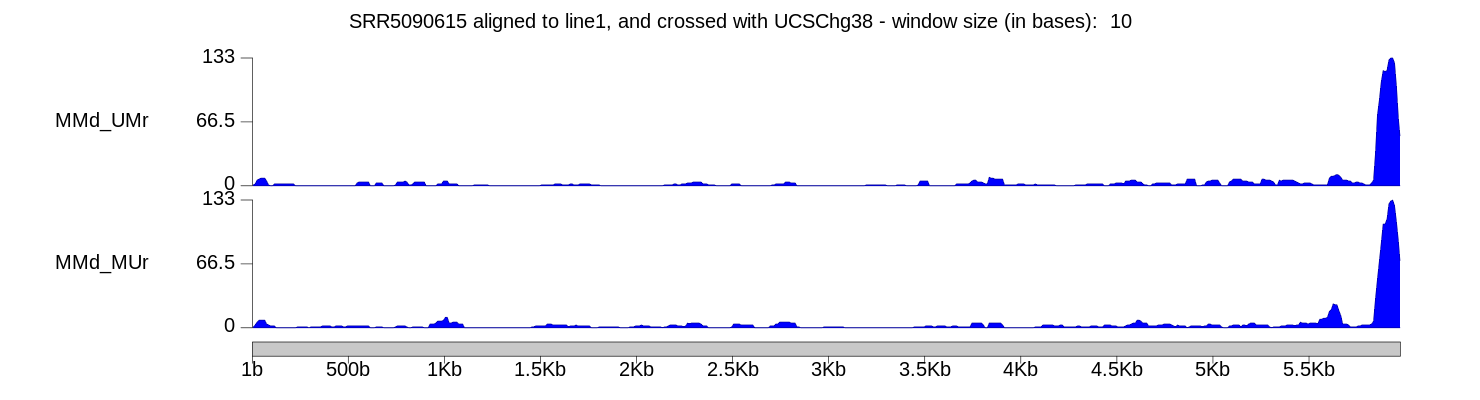

#### Recipient reads density graph

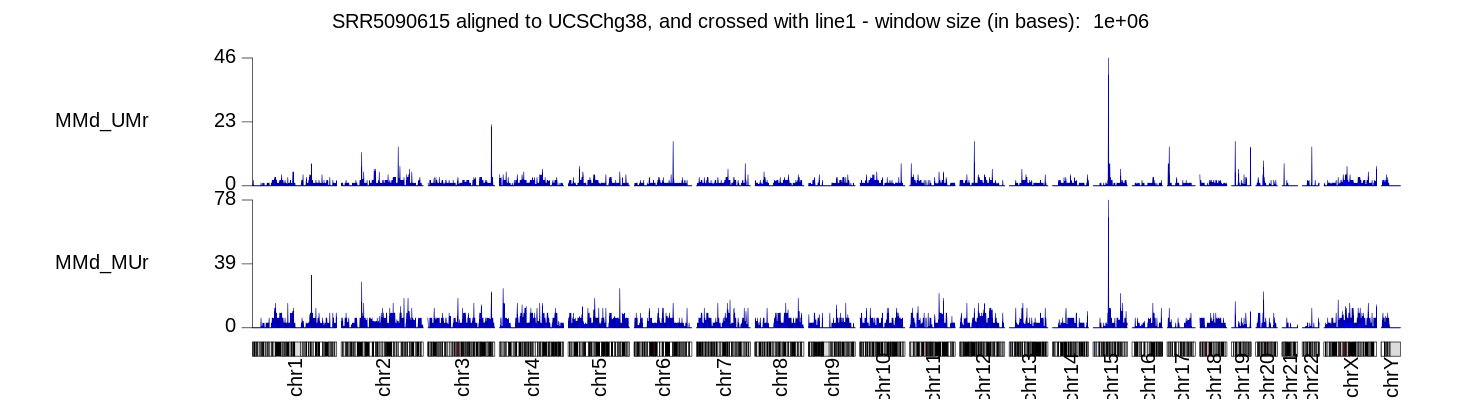

#### Crossings overlap graph - Putative insertion site

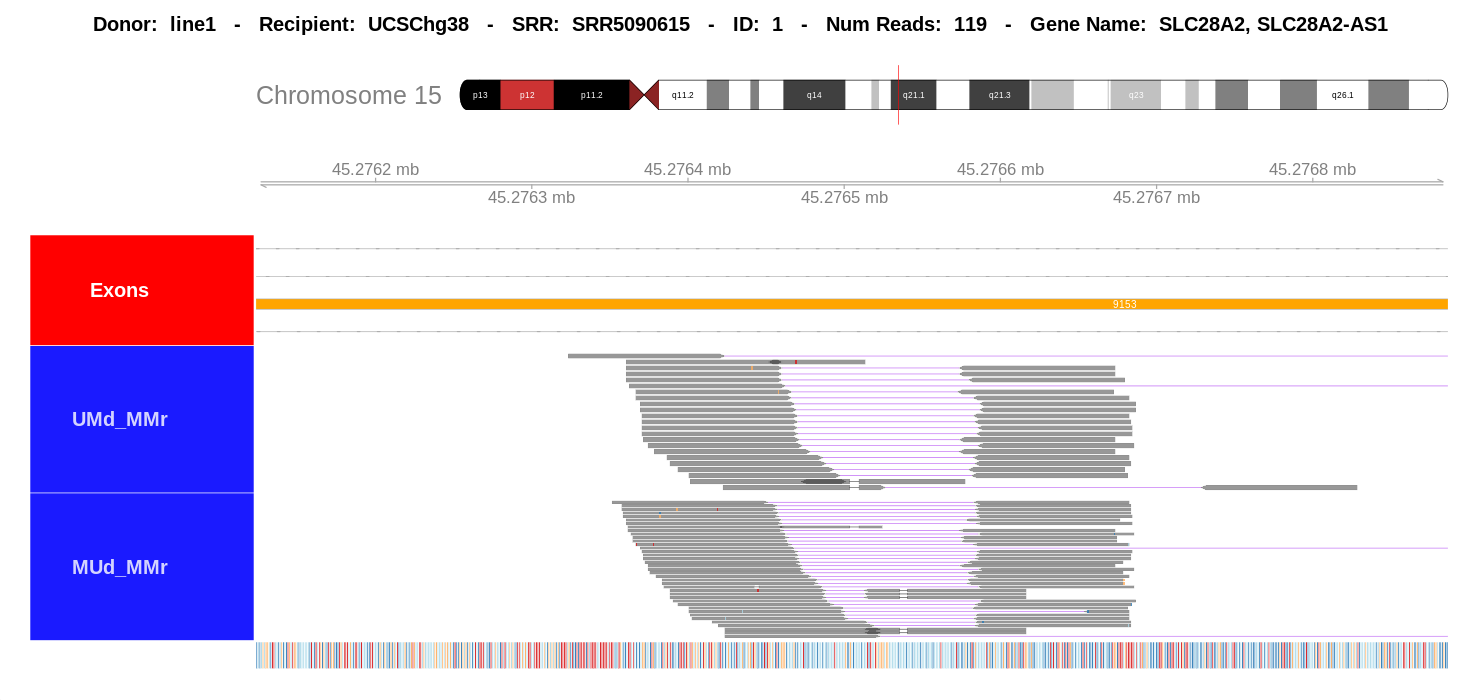

### SRR5090617

#### Donor reads density graph

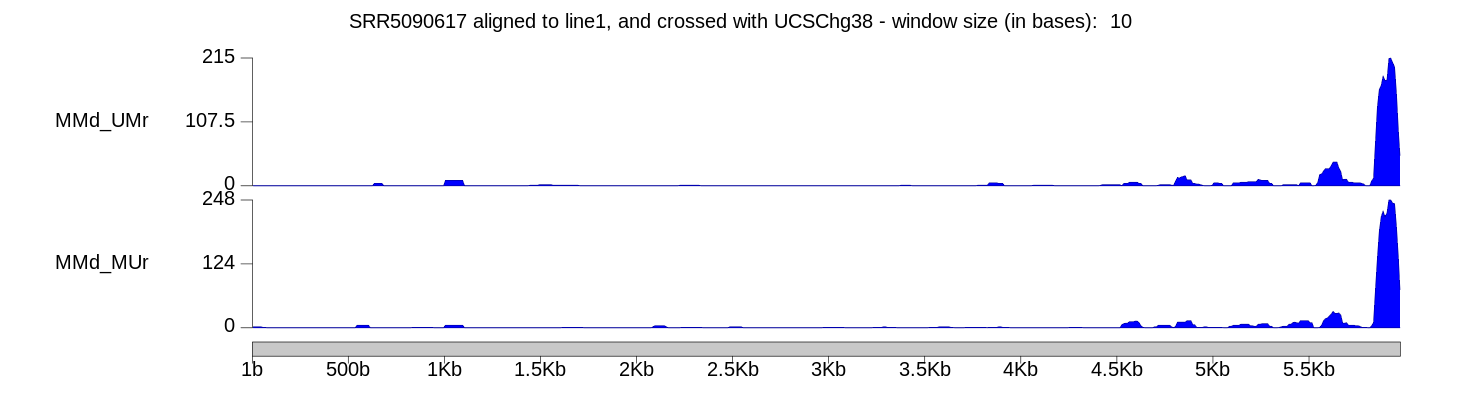

#### Recipient reads density graph

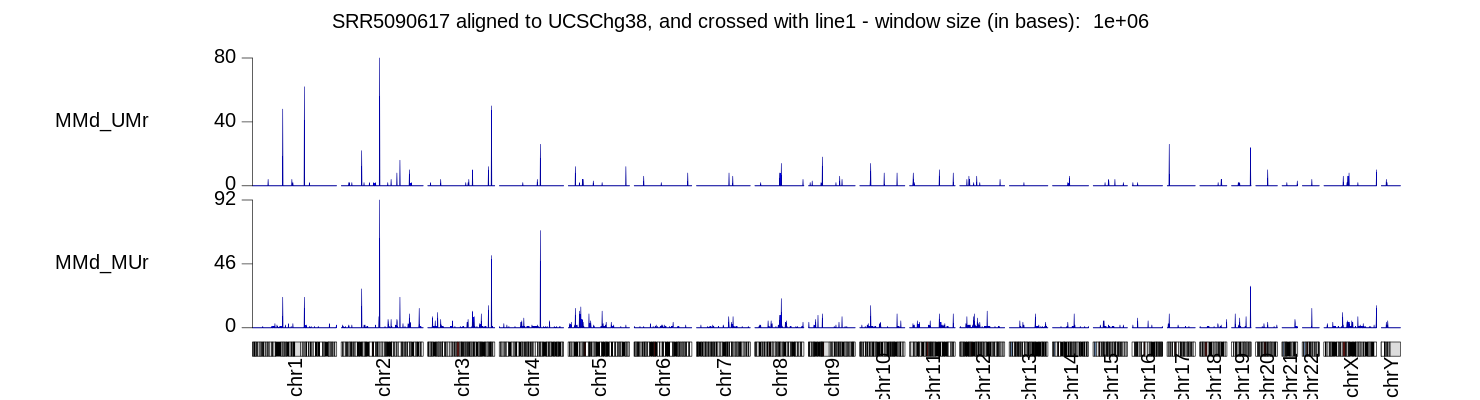

#### Crossings overlap graph - Putative insertion site

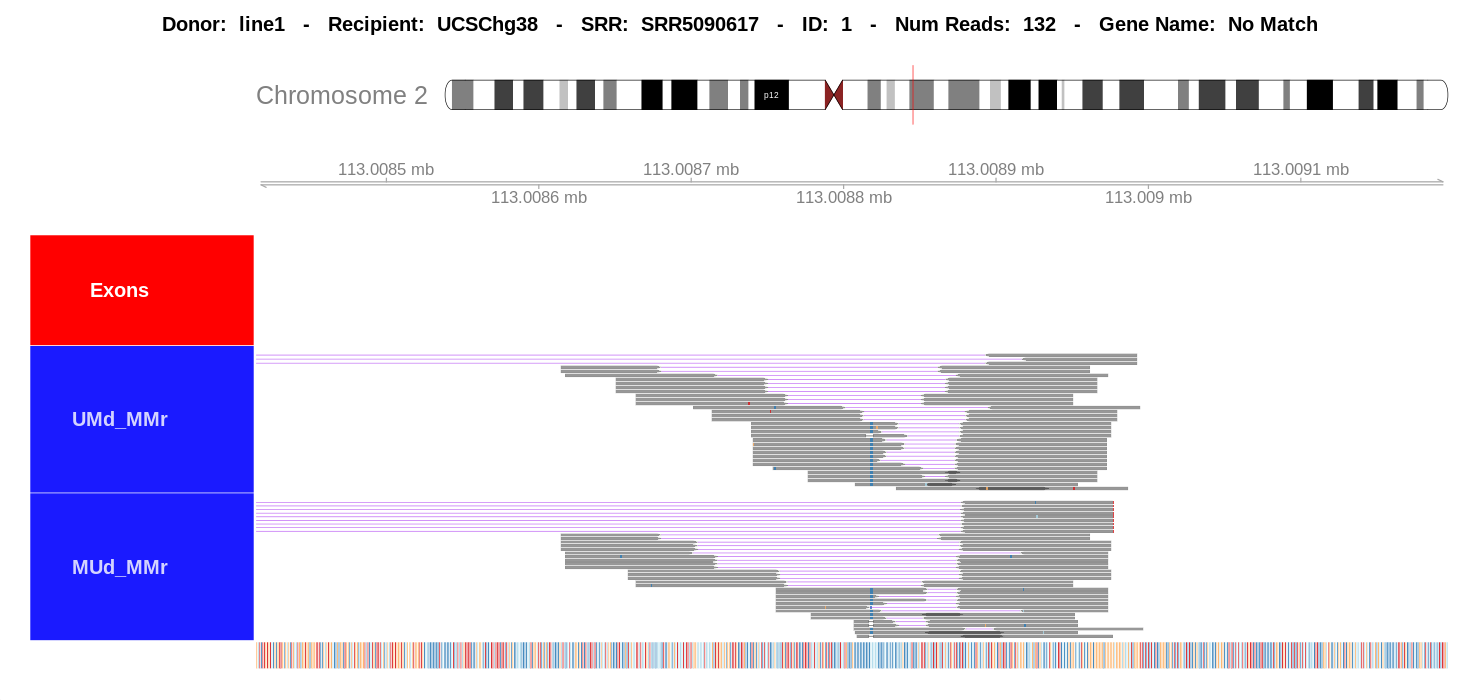

### SRR5090635

#### Donor reads density graph

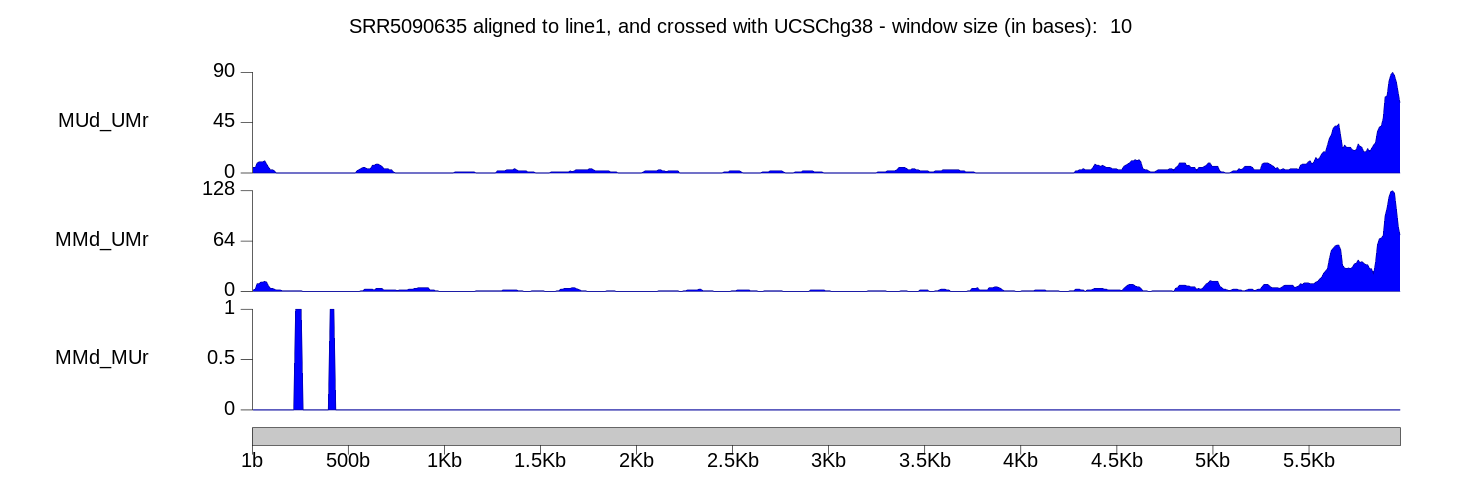

#### Recipient reads density graph

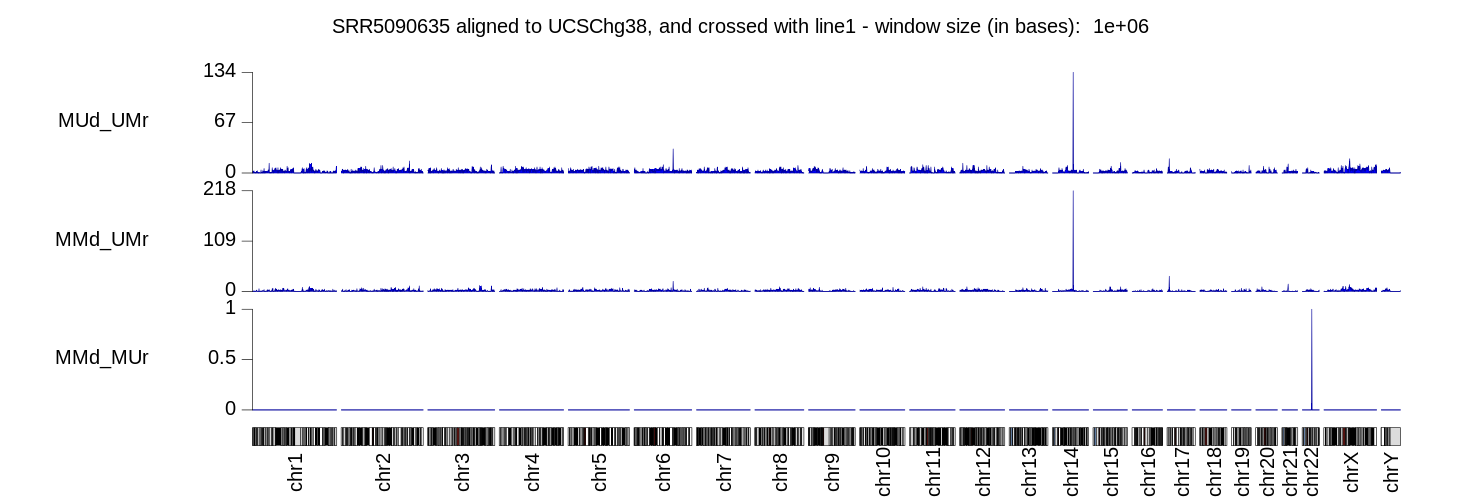

#### Crossings overlap graph - Putative insertion site

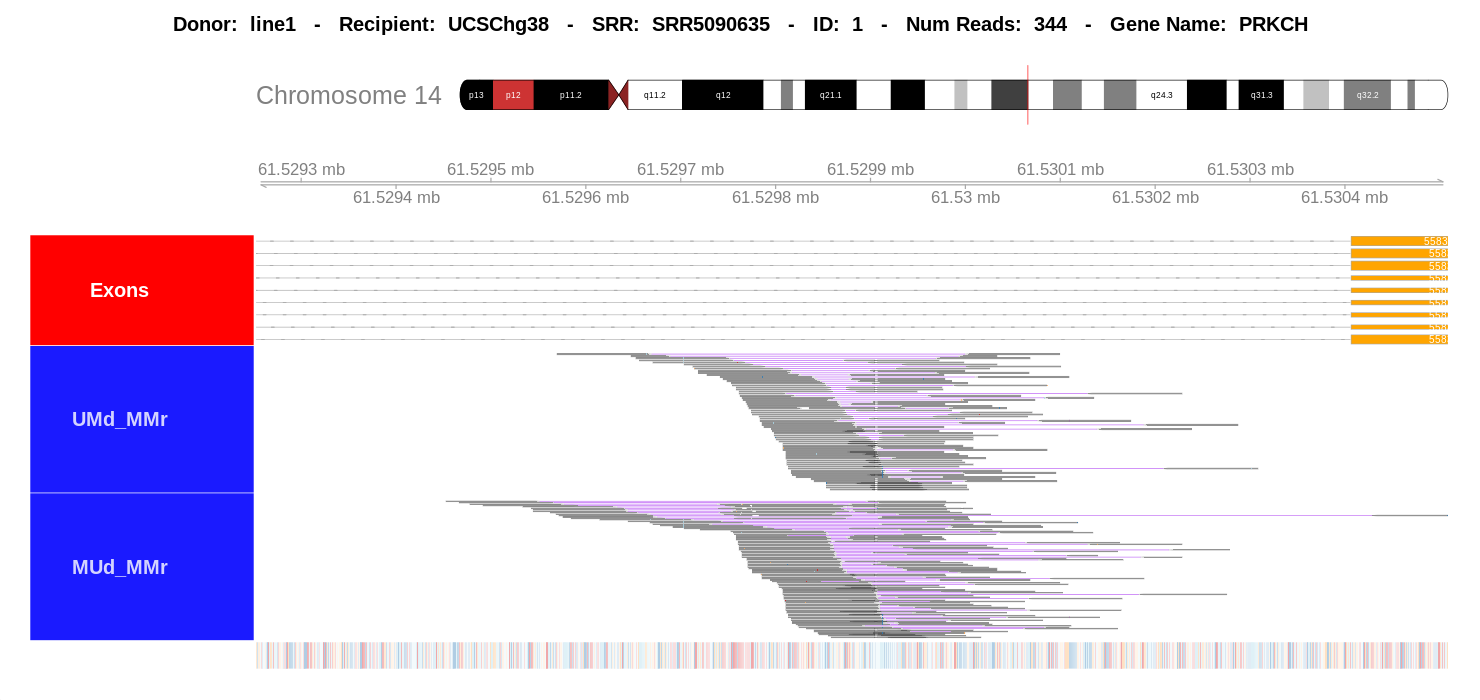

### SRR5090637

#### Donor reads density graph

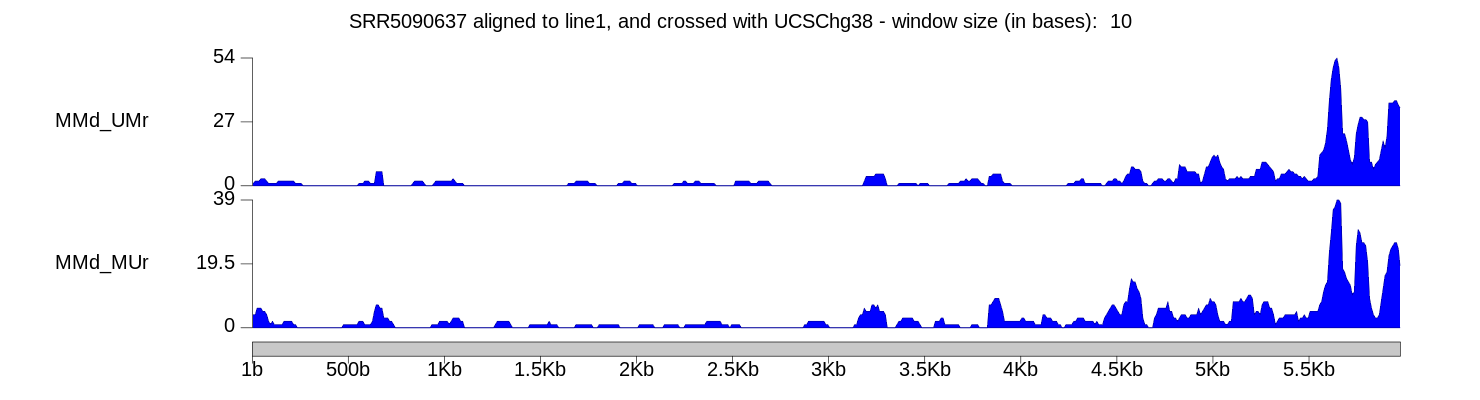

#### Recipient reads density graph

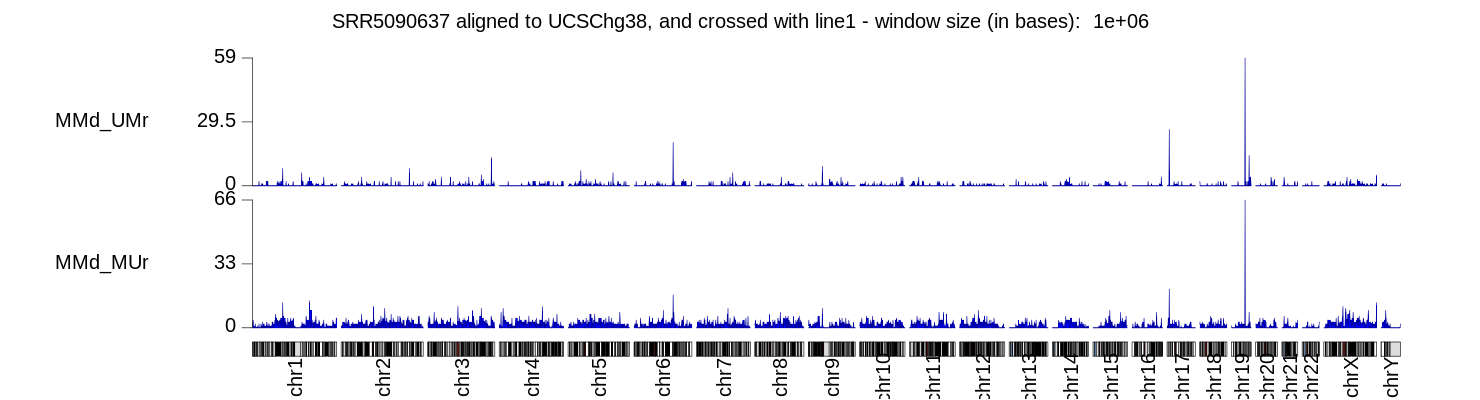

#### Crossings overlap graph - Putative insertion site

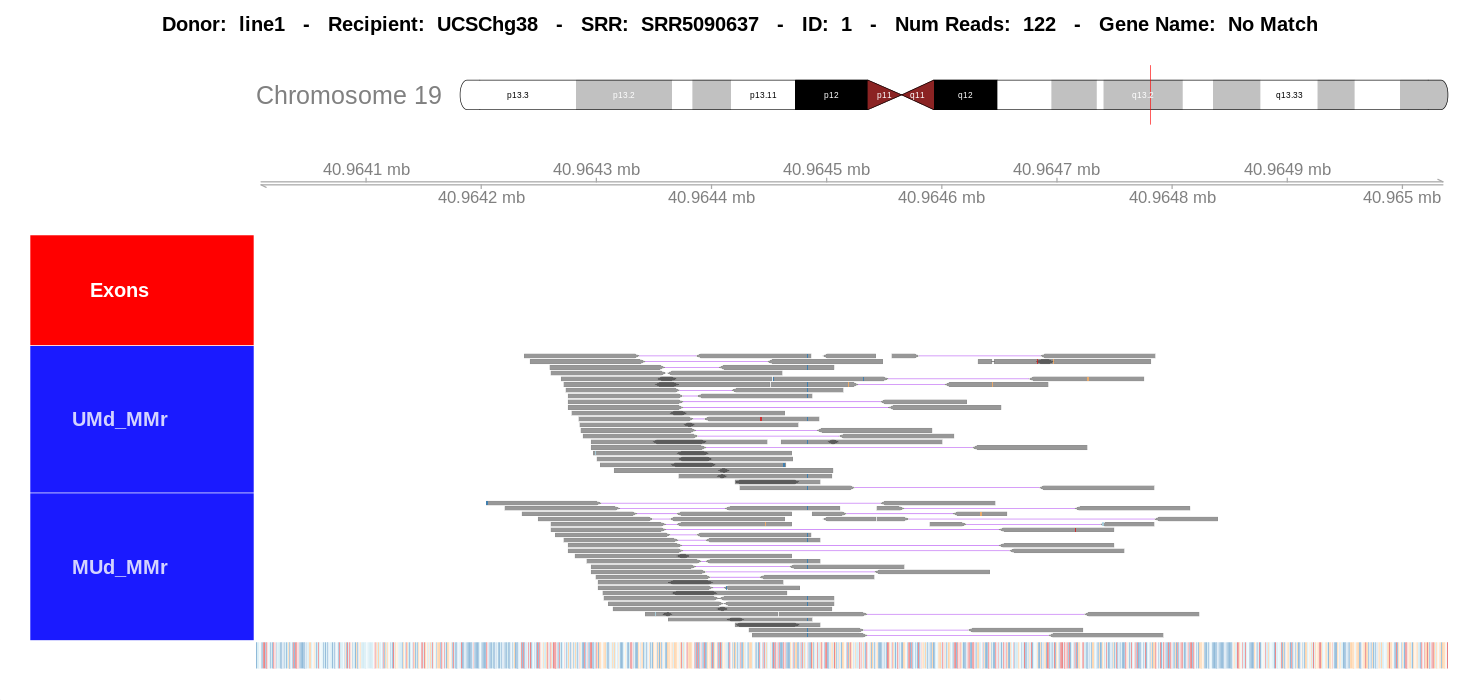

### SRR1106189

#### Donor reads density graph

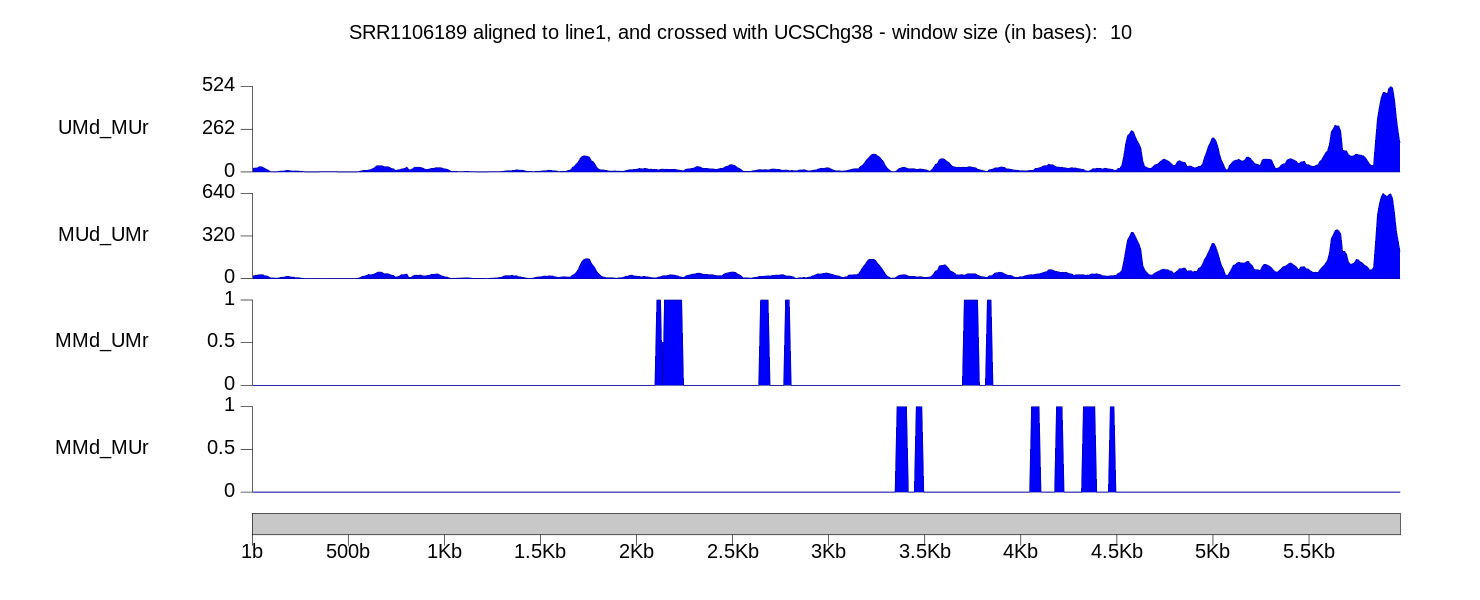

#### Recipient reads density graph

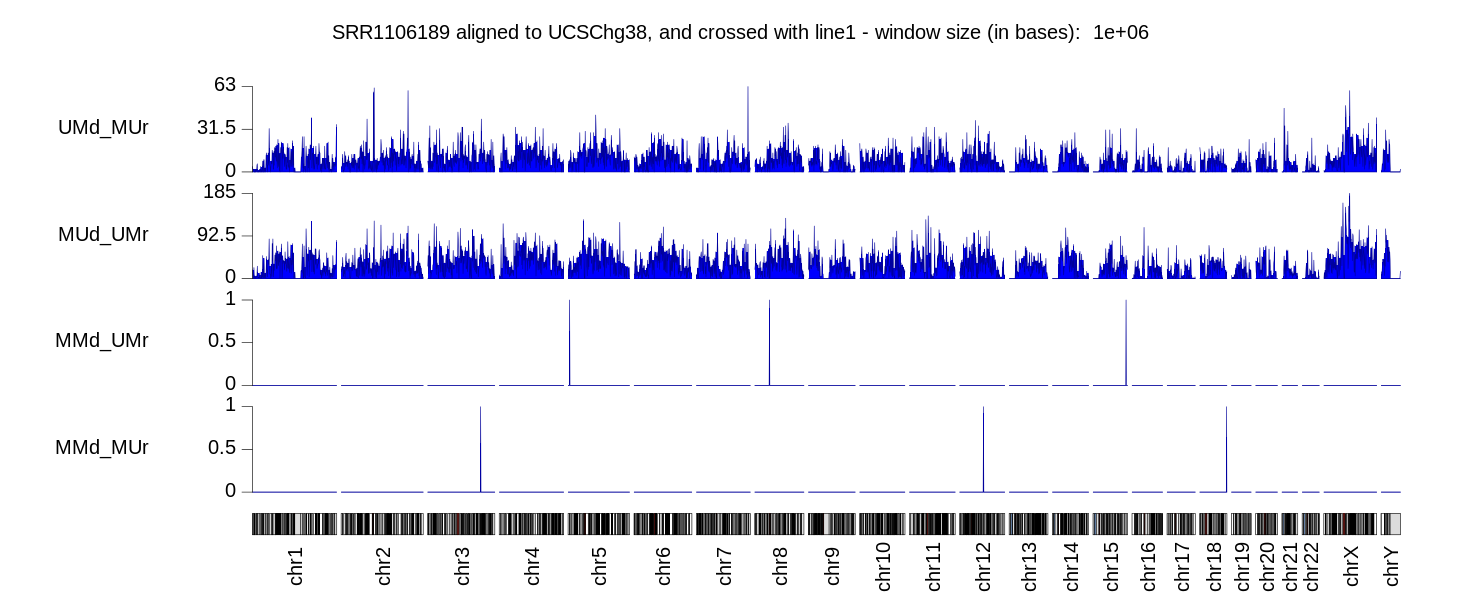

#### Crossings overlap graph - Putative insertion site

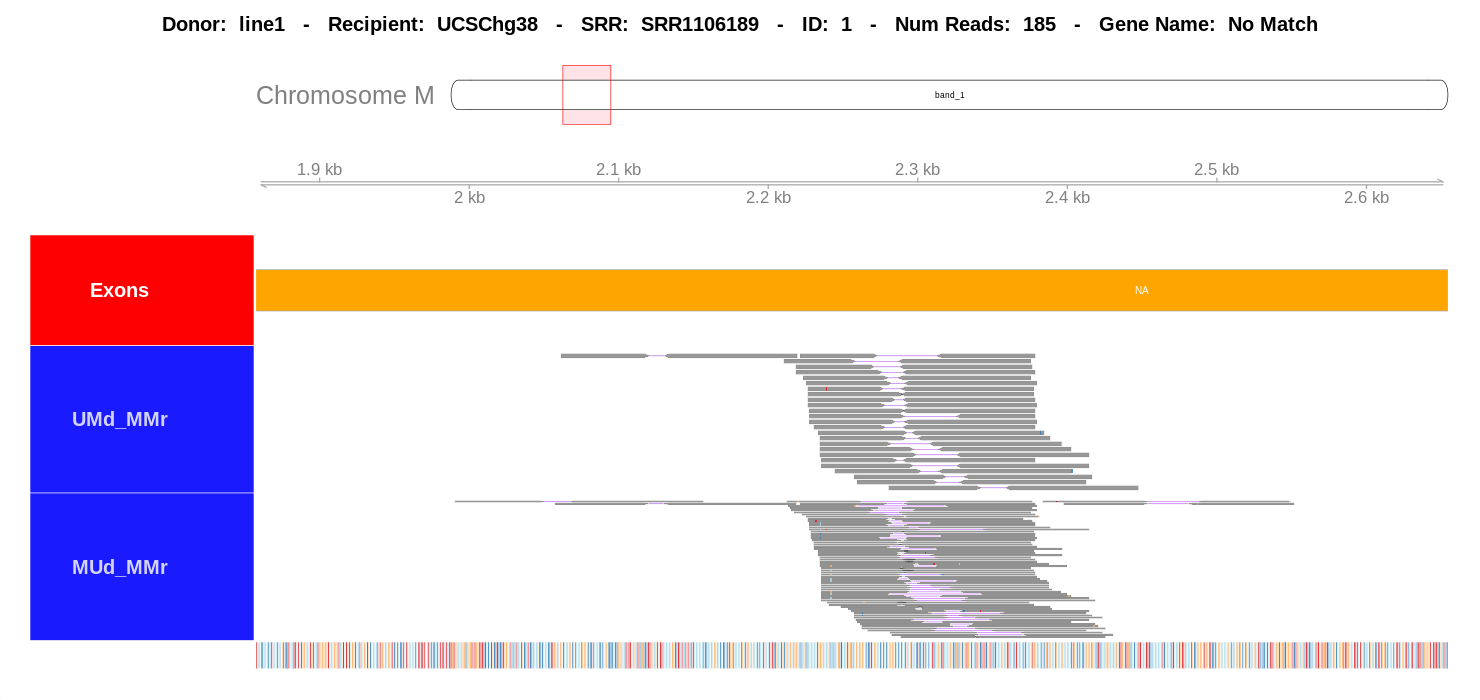

### SRR1106191

#### Donor reads density graph

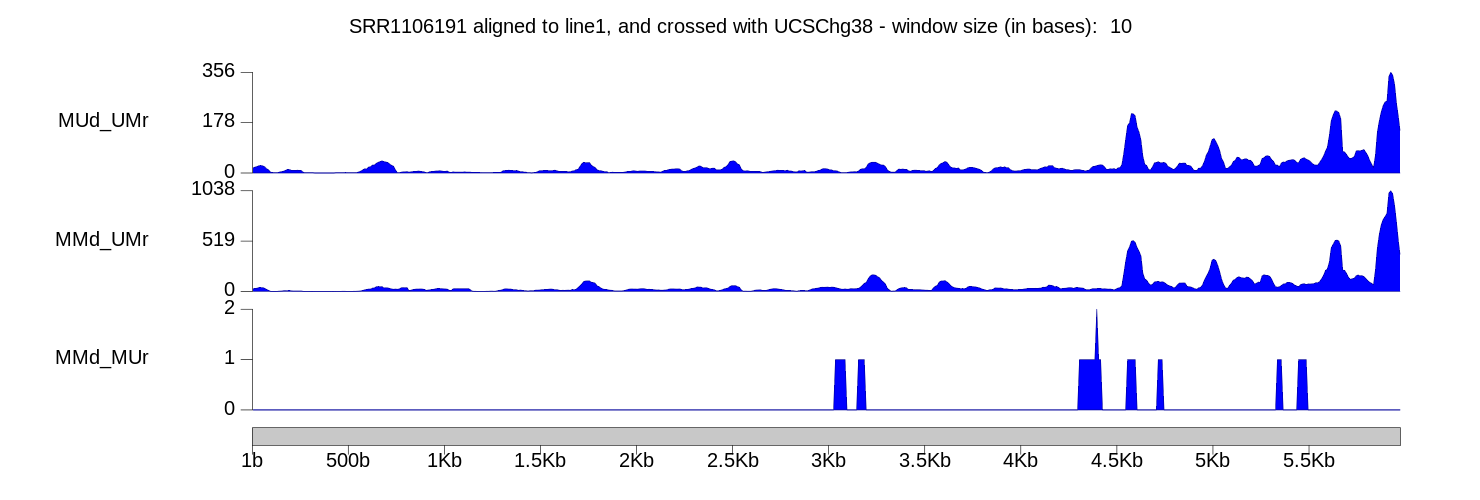

#### Recipient reads density graph

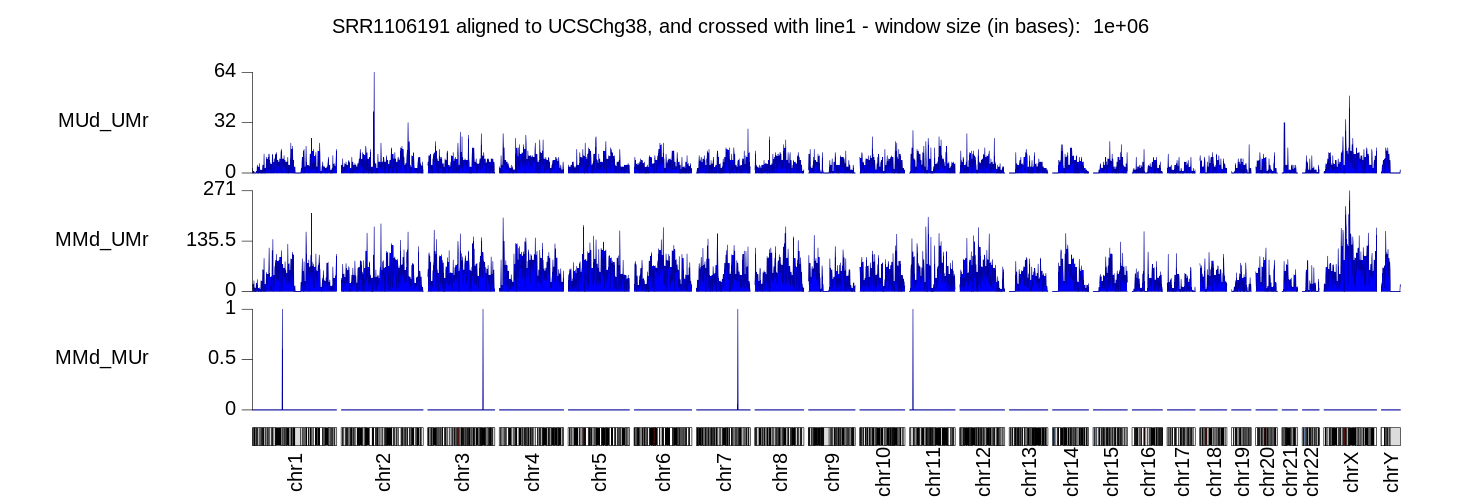

#### Crossings overlap graph - Putative insertion site

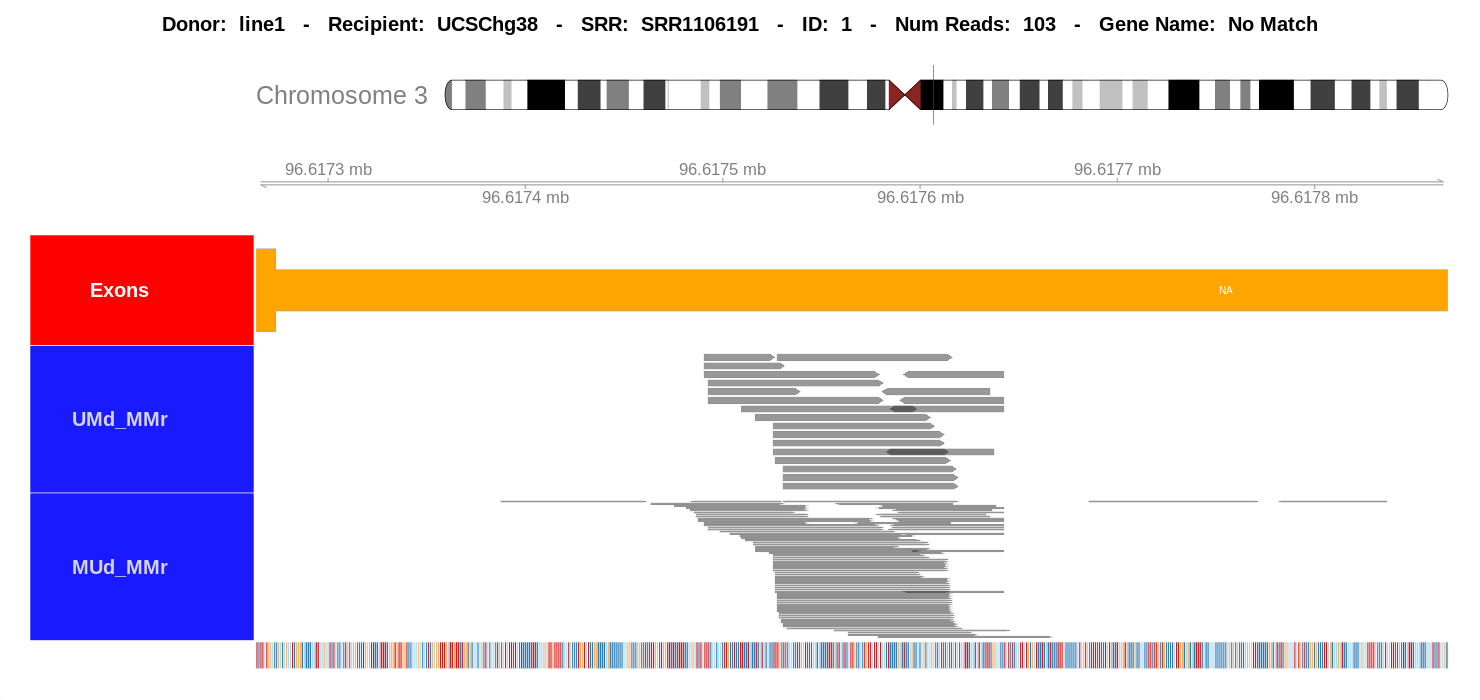

#### Crossings overlap graph - Putative insertion site

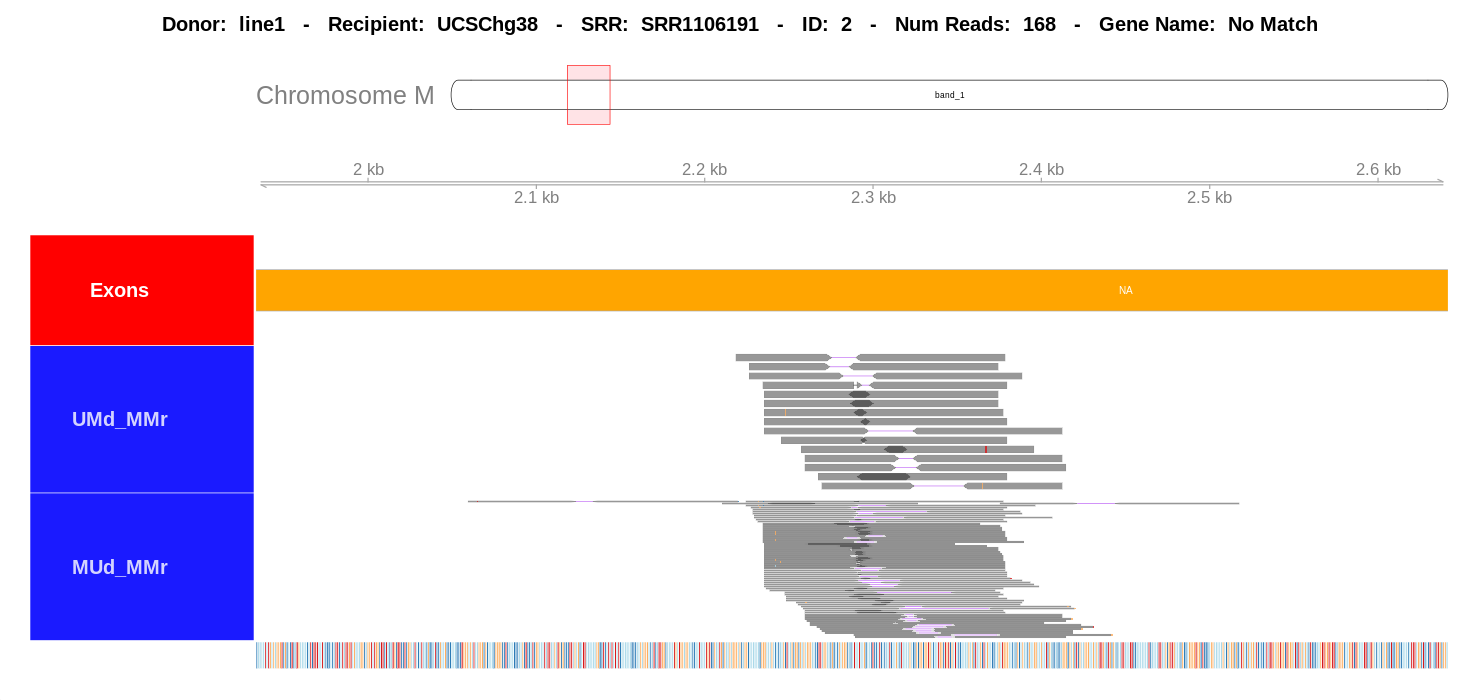

### SRR1106192

#### Donor reads density graph

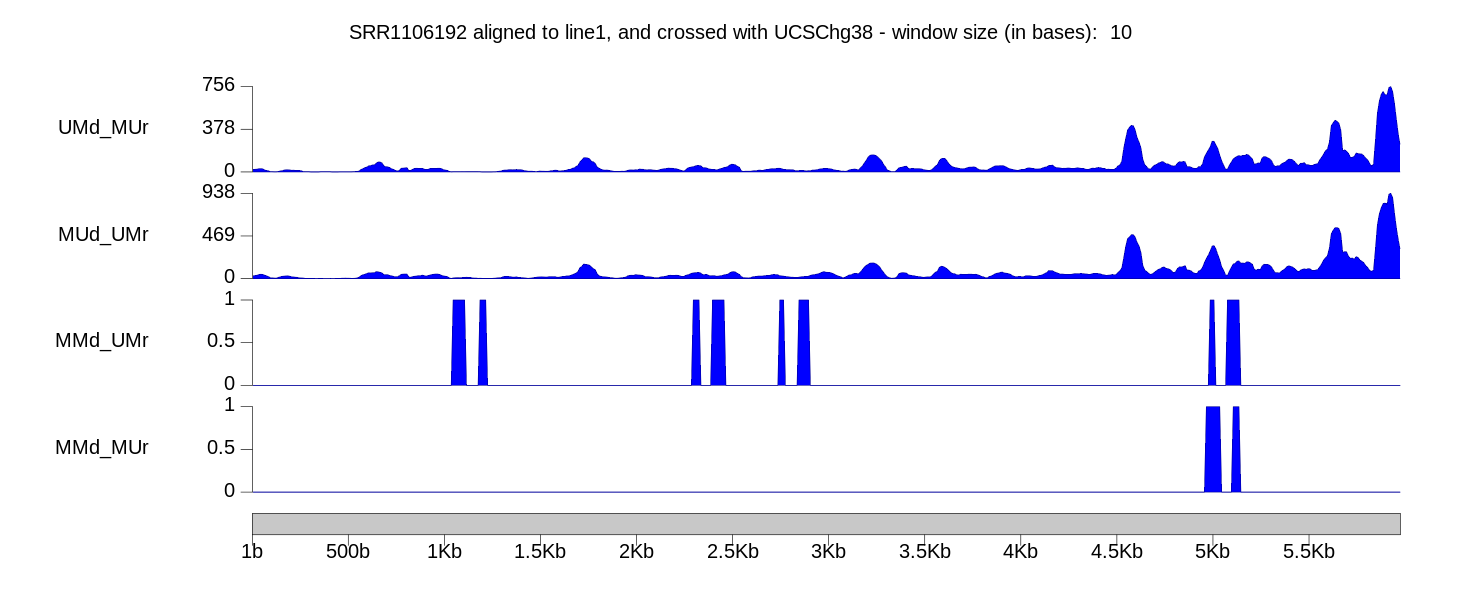

#### Recipient reads density graph

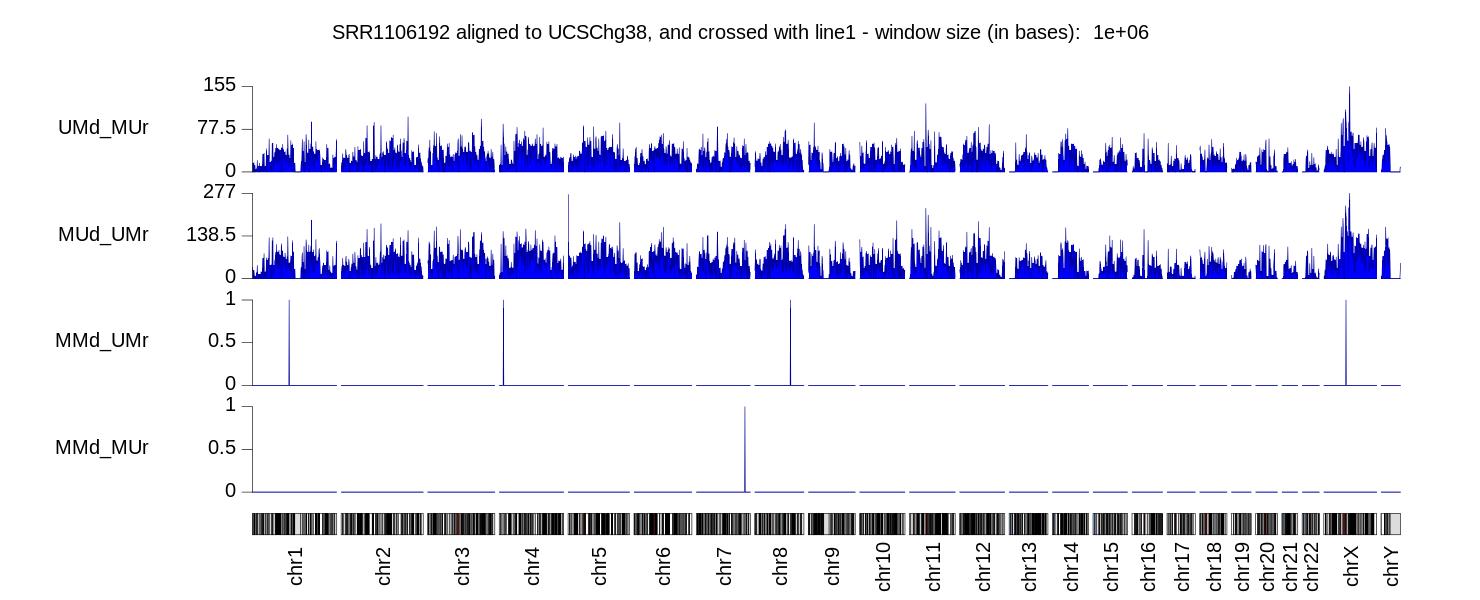

#### Crossings overlap graph - Putative insertion site

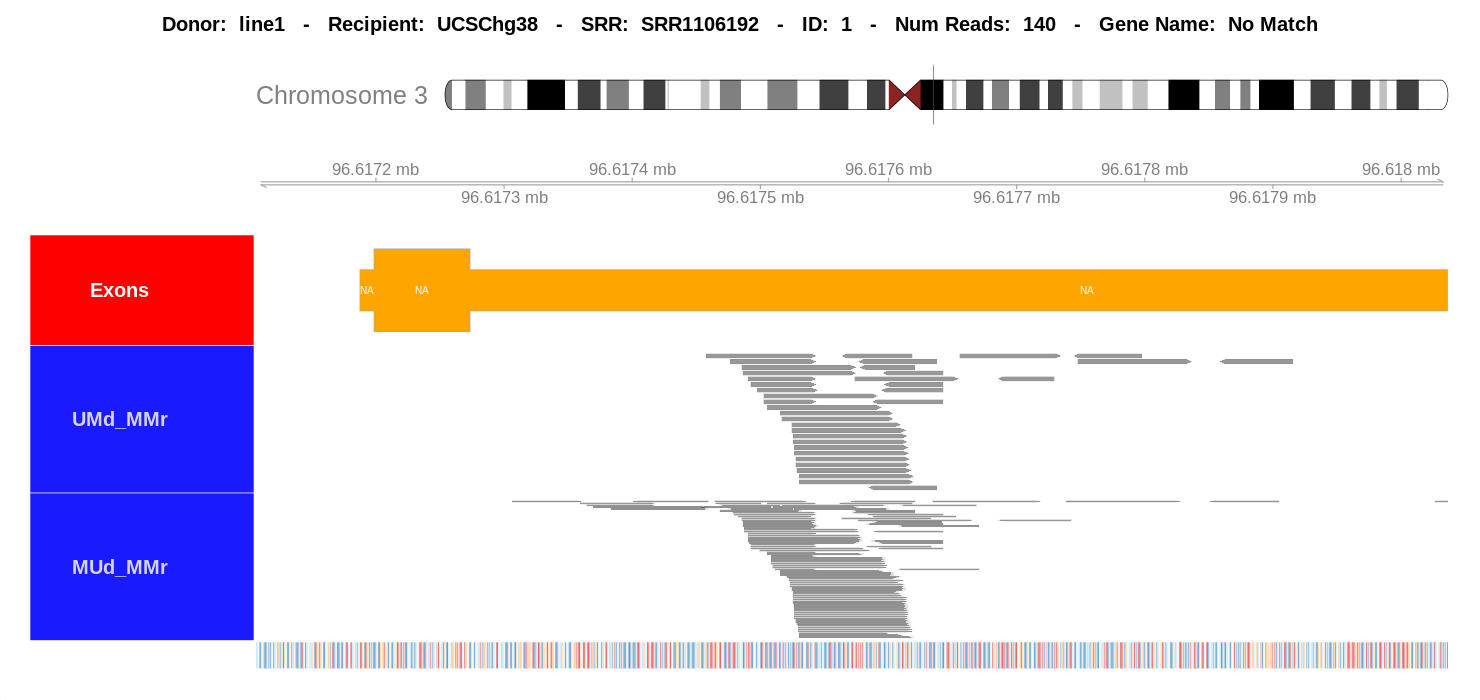

#### Crossings overlap graph - Putative insertion site

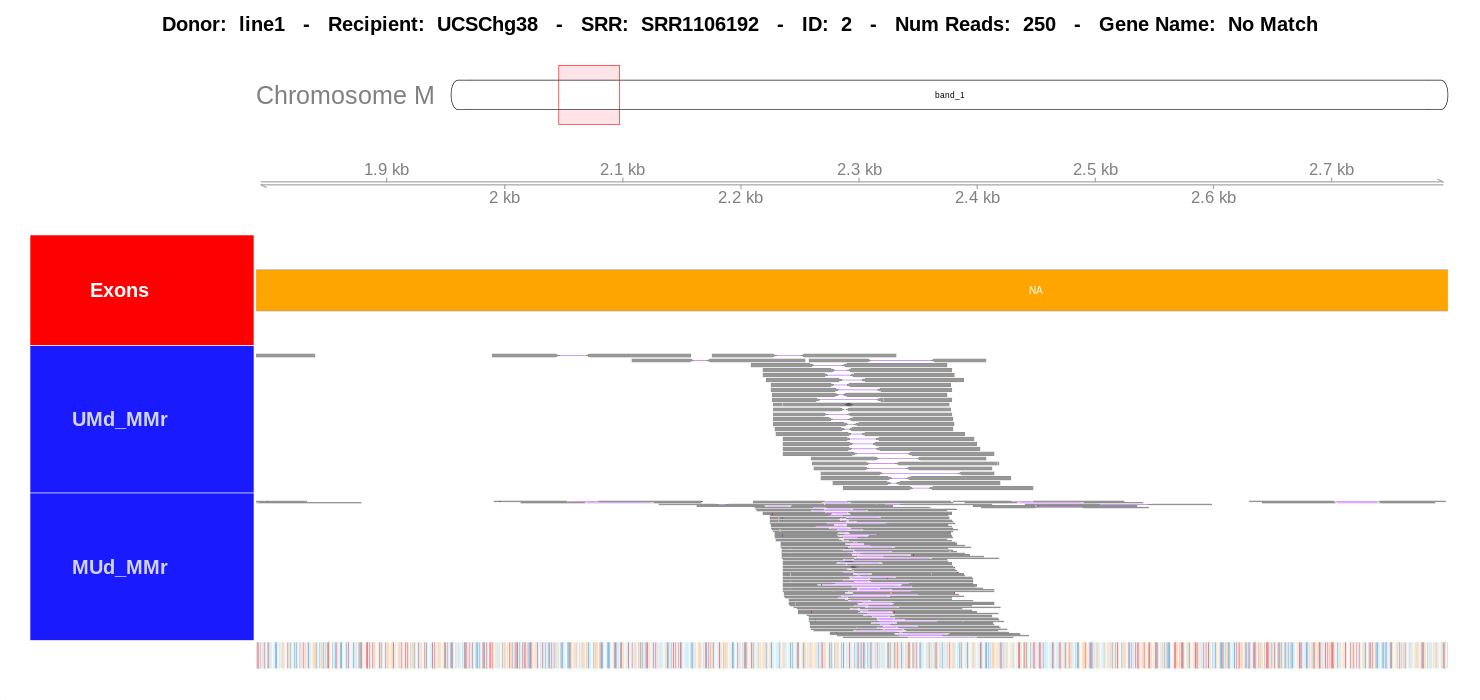

#### Crossings overlap graph - Putative insertion site

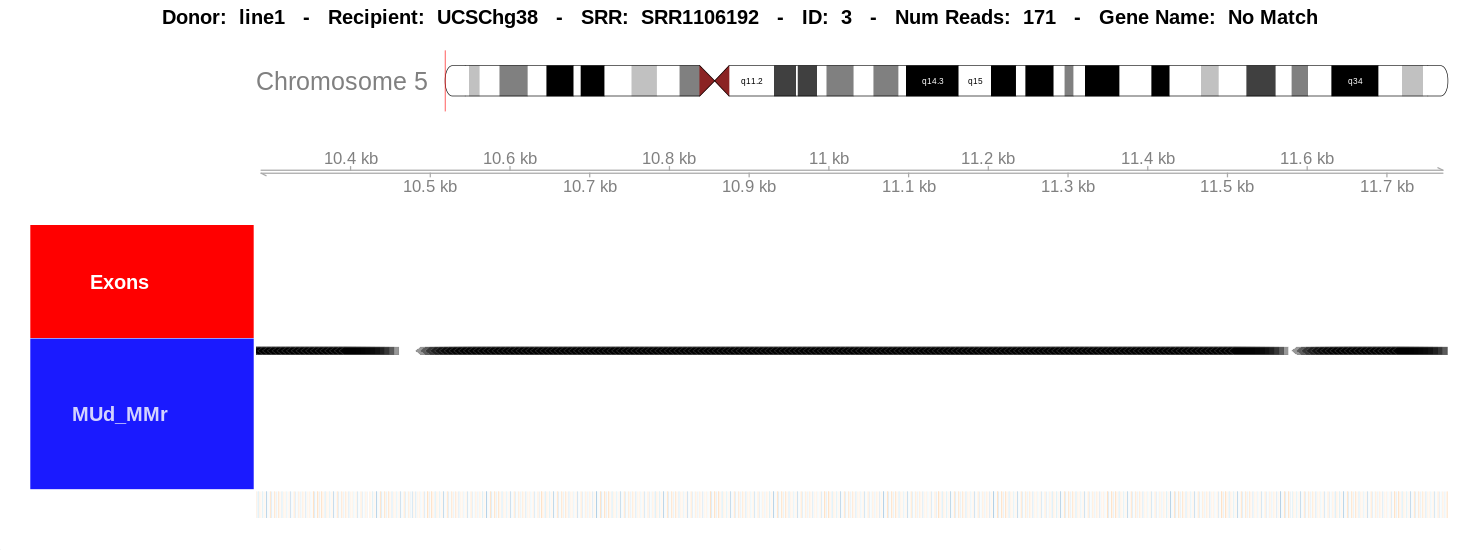

### SRR1106193

#### Donor reads density graph

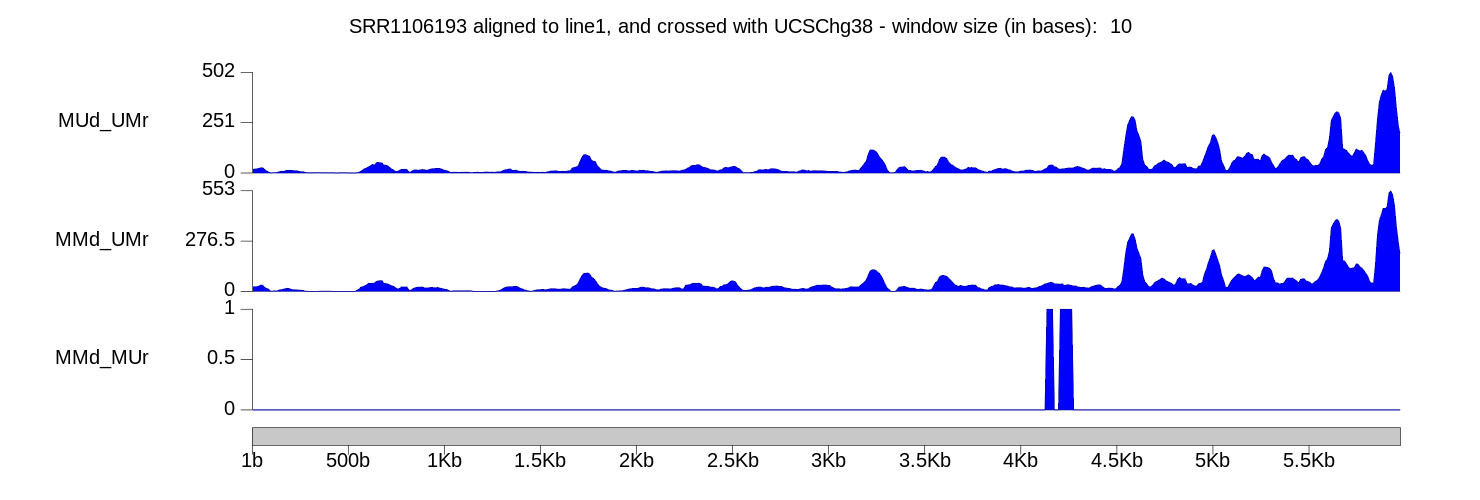

#### Recipient reads density graph

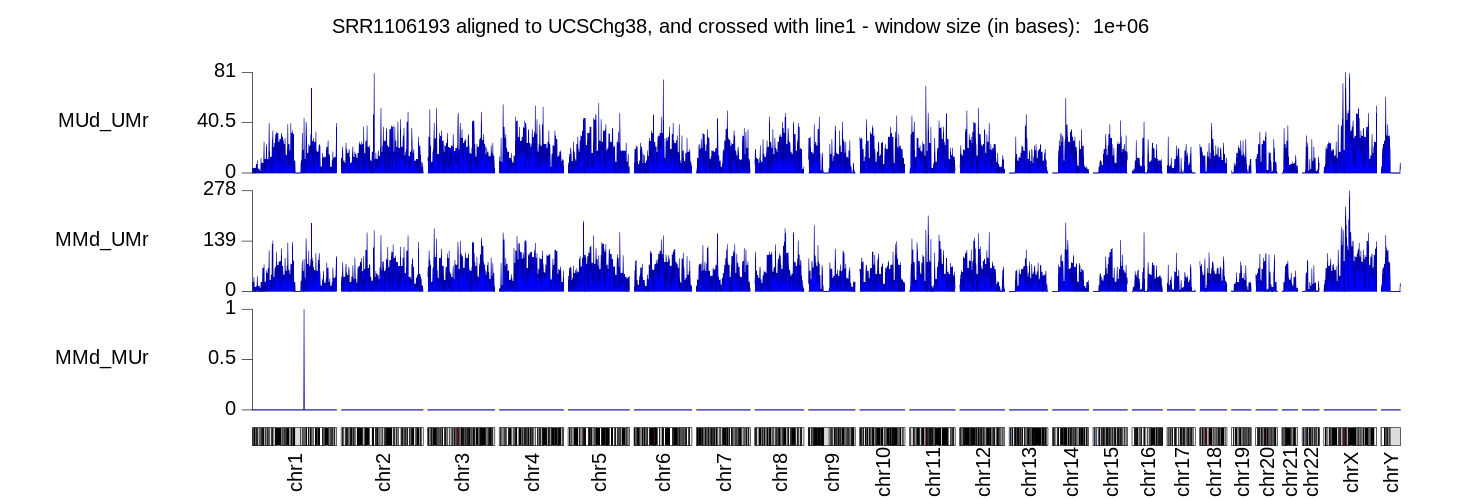

#### Crossings overlap graph - Putative insertion site

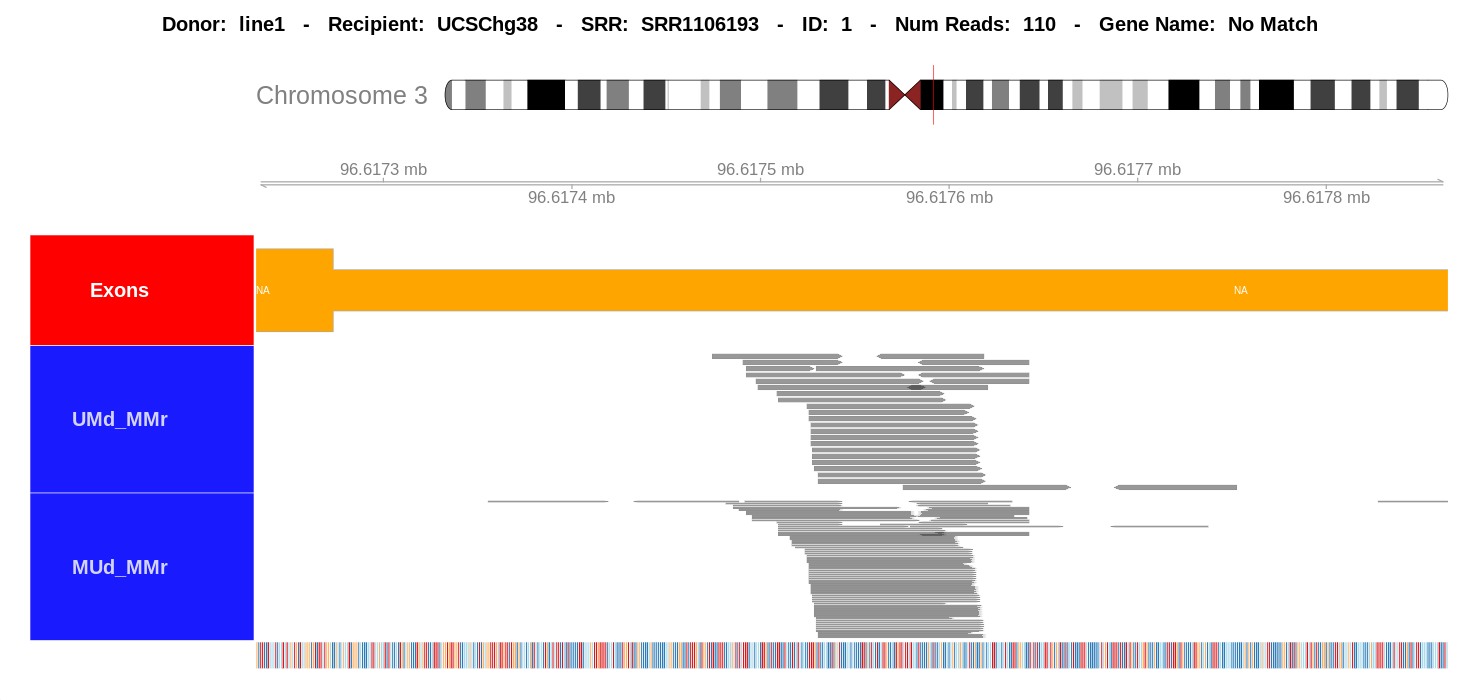

#### Crossings overlap graph - Putative insertion site

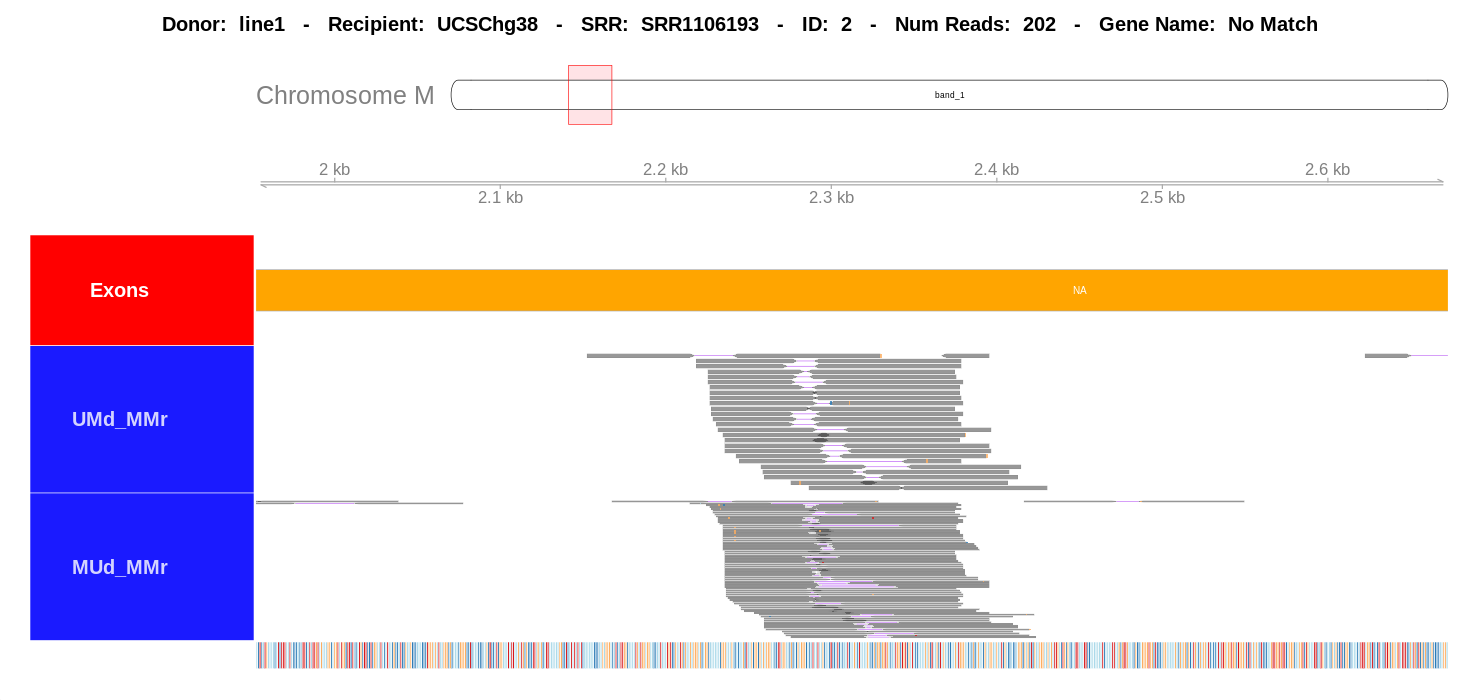

### SRR1106194

#### Donor reads density graph

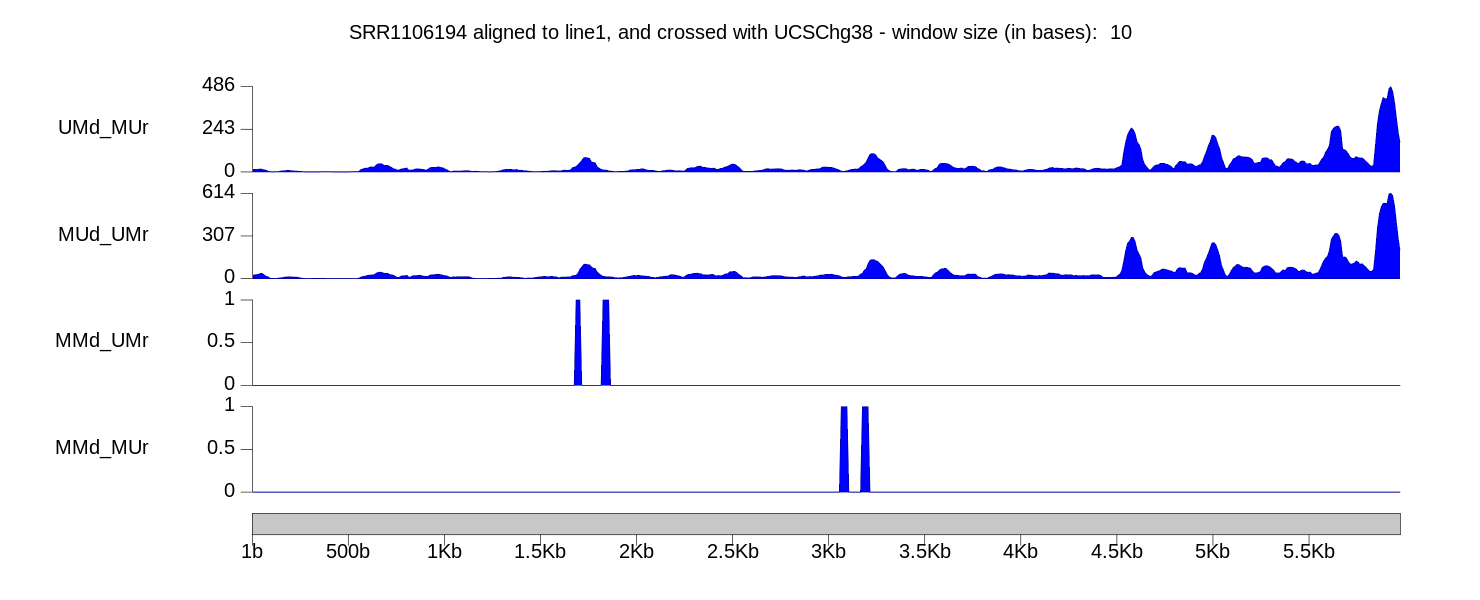

#### Recipient reads density graph

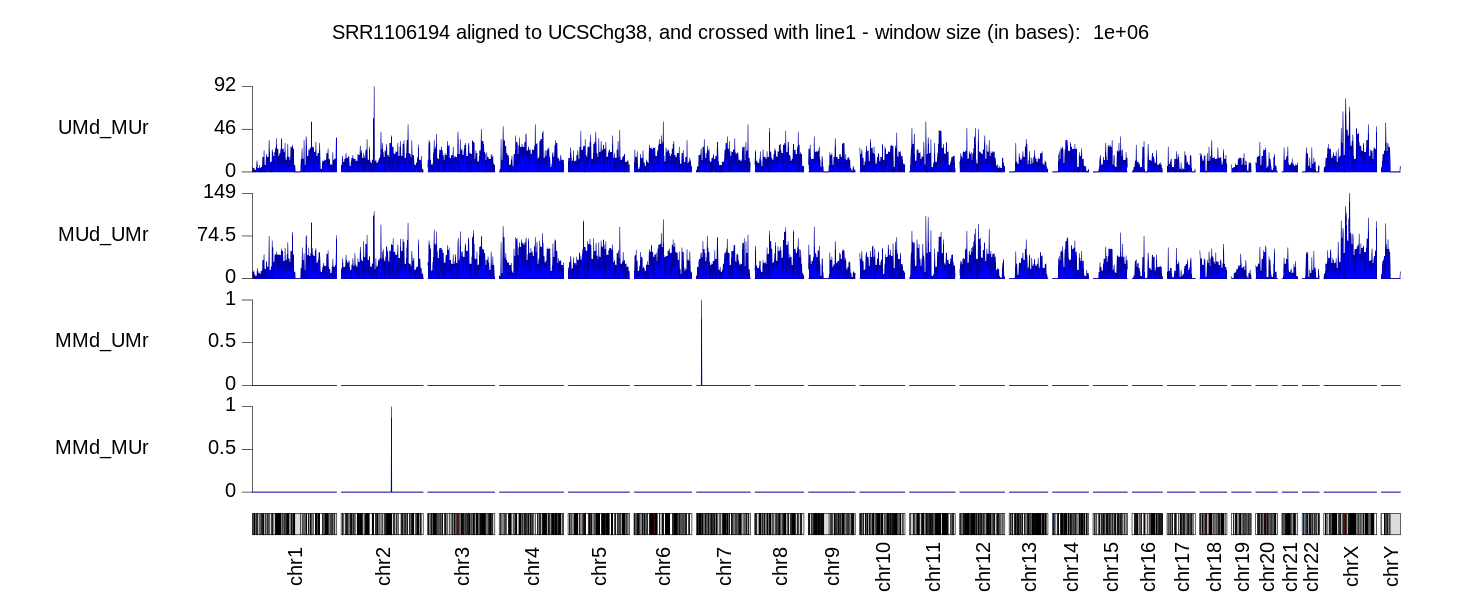

#### Crossings overlap graph - Putative insertion site

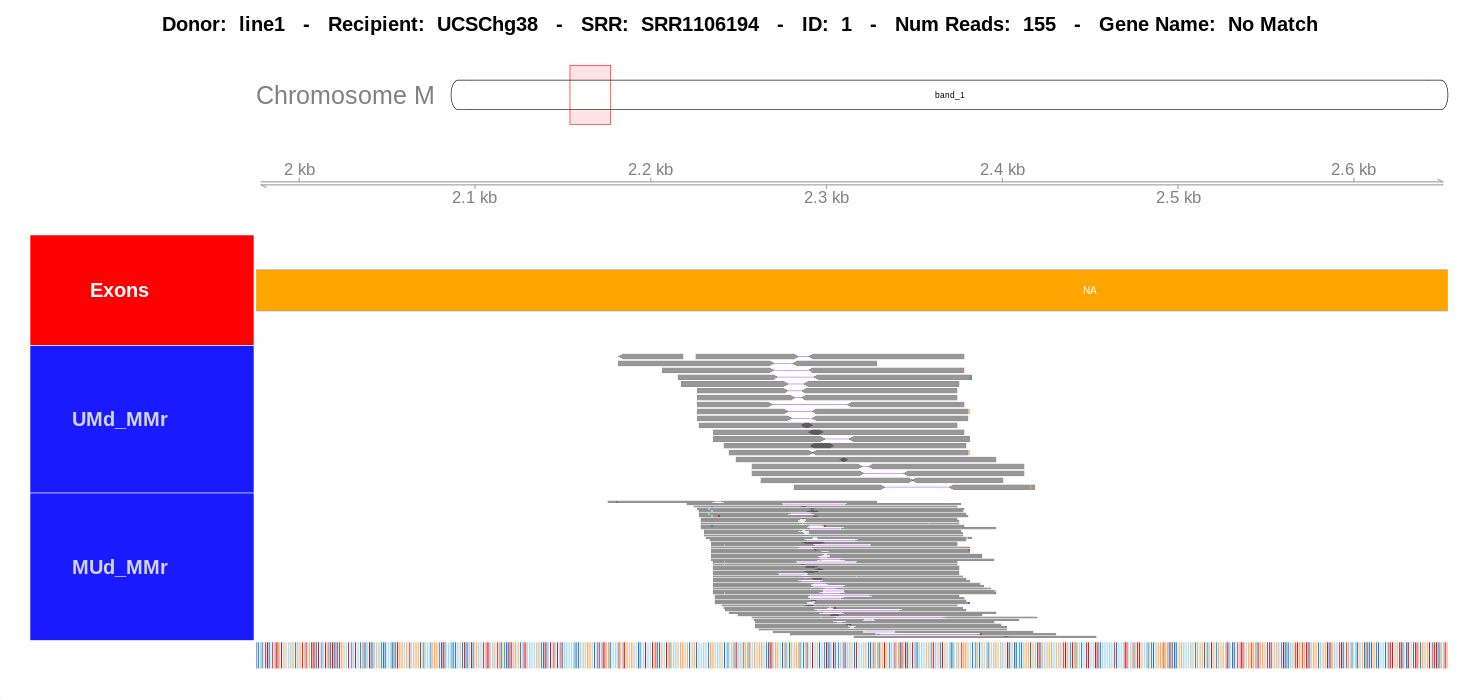

### SRR1106195

#### Donor reads density graph

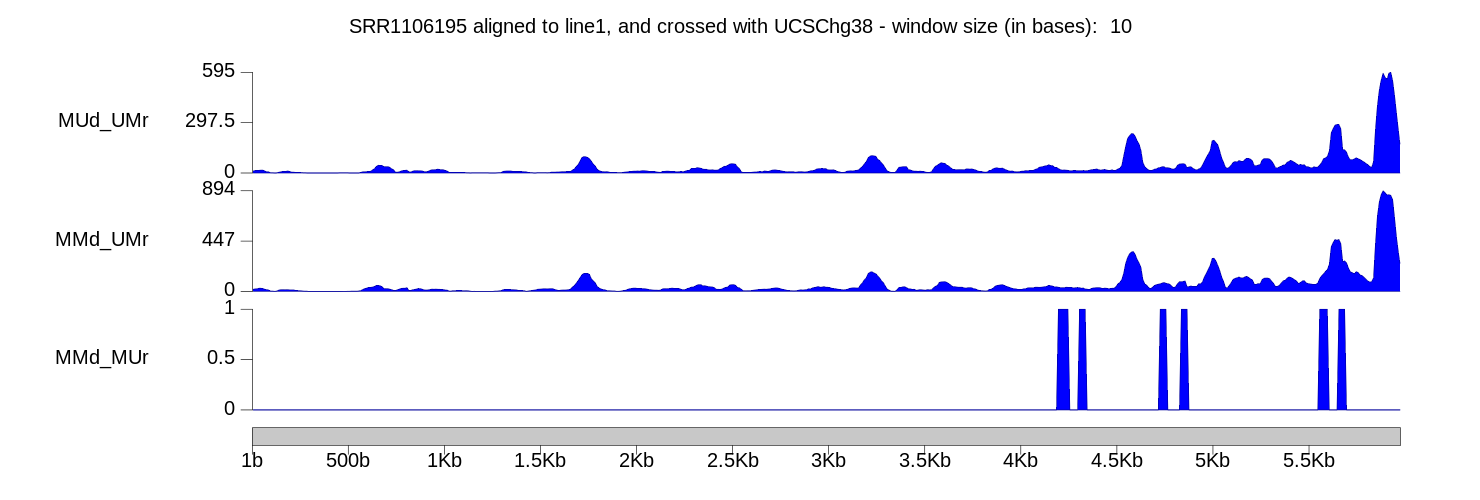

#### Recipient reads density graph

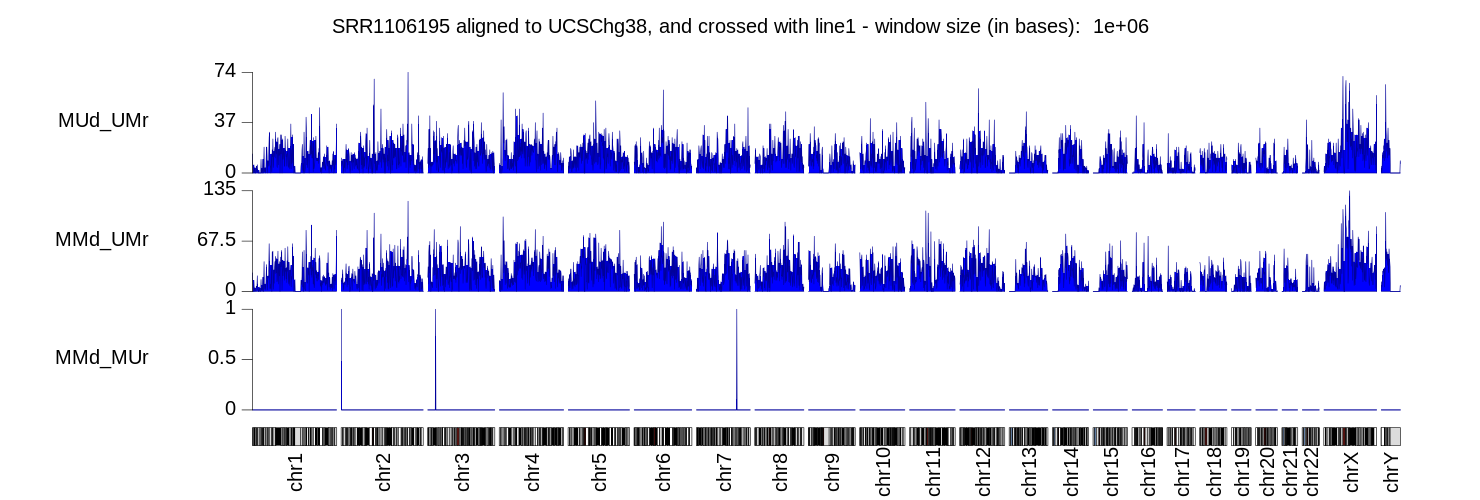

#### Crossings overlap graph - Putative insertion site

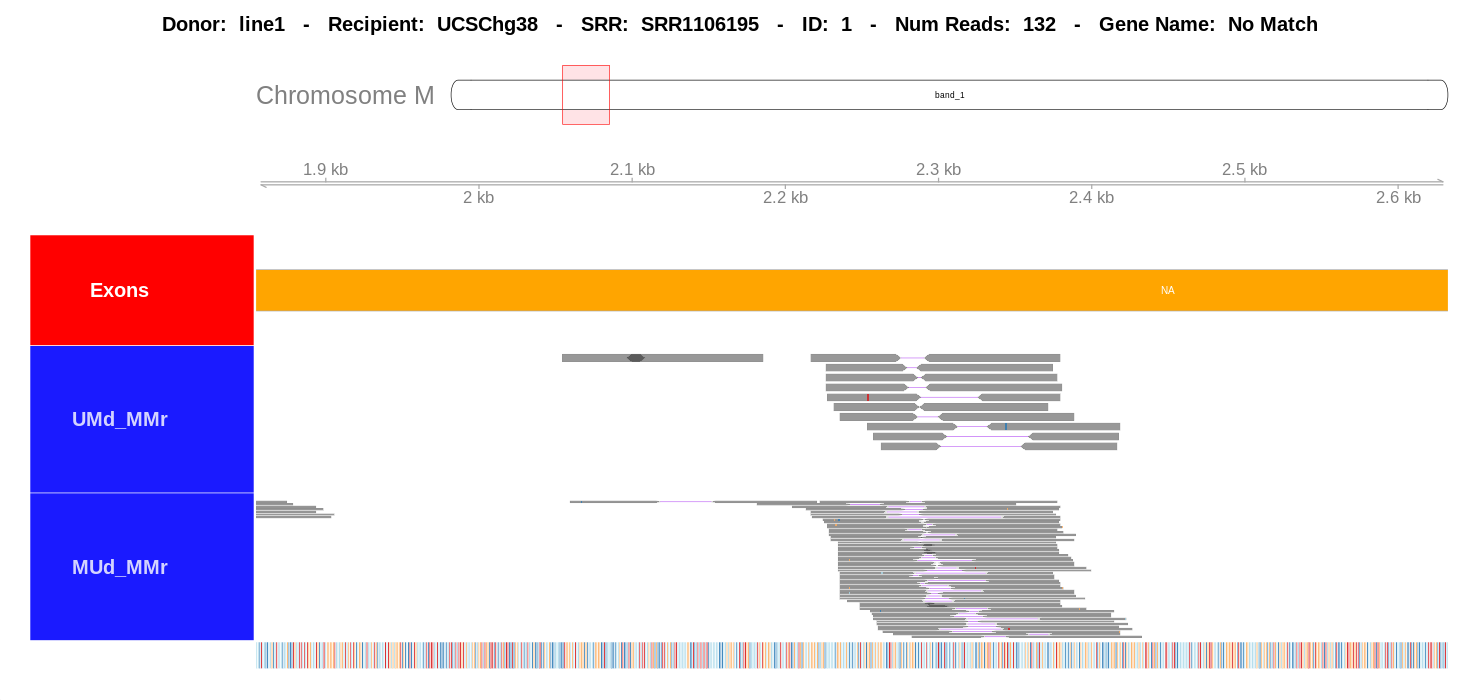

### SRR1106197

#### Donor reads density graph

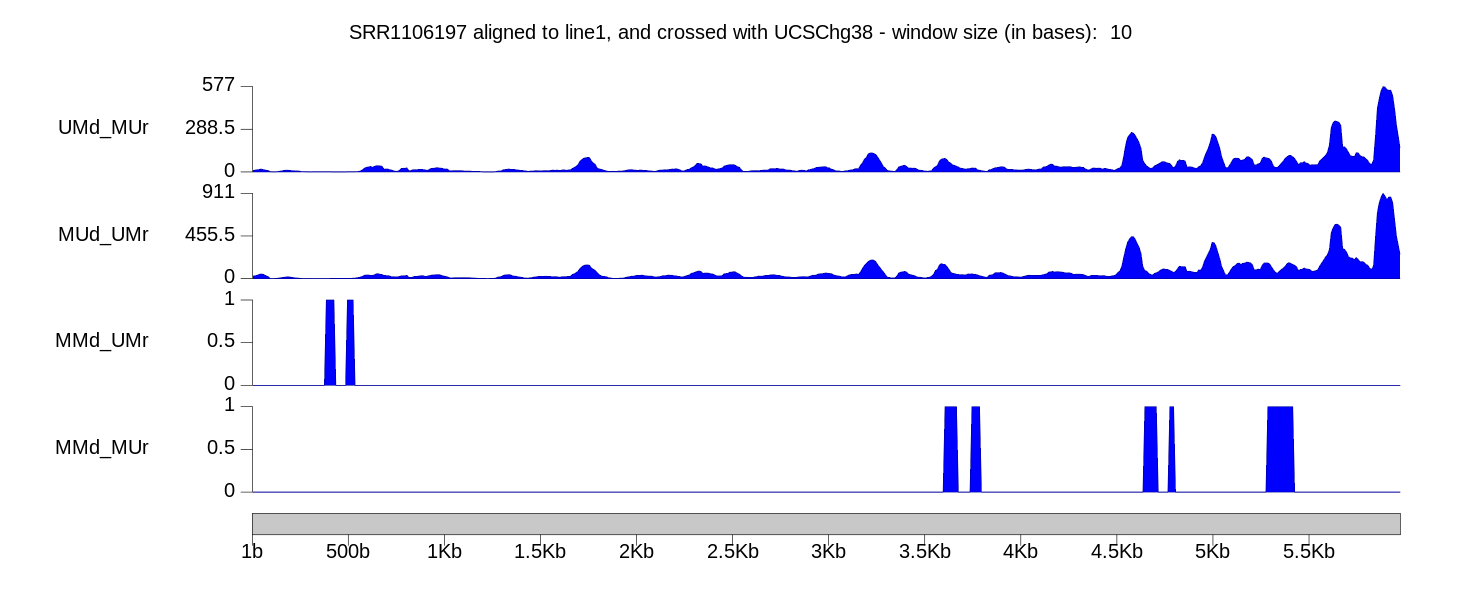

#### Recipient reads density graph

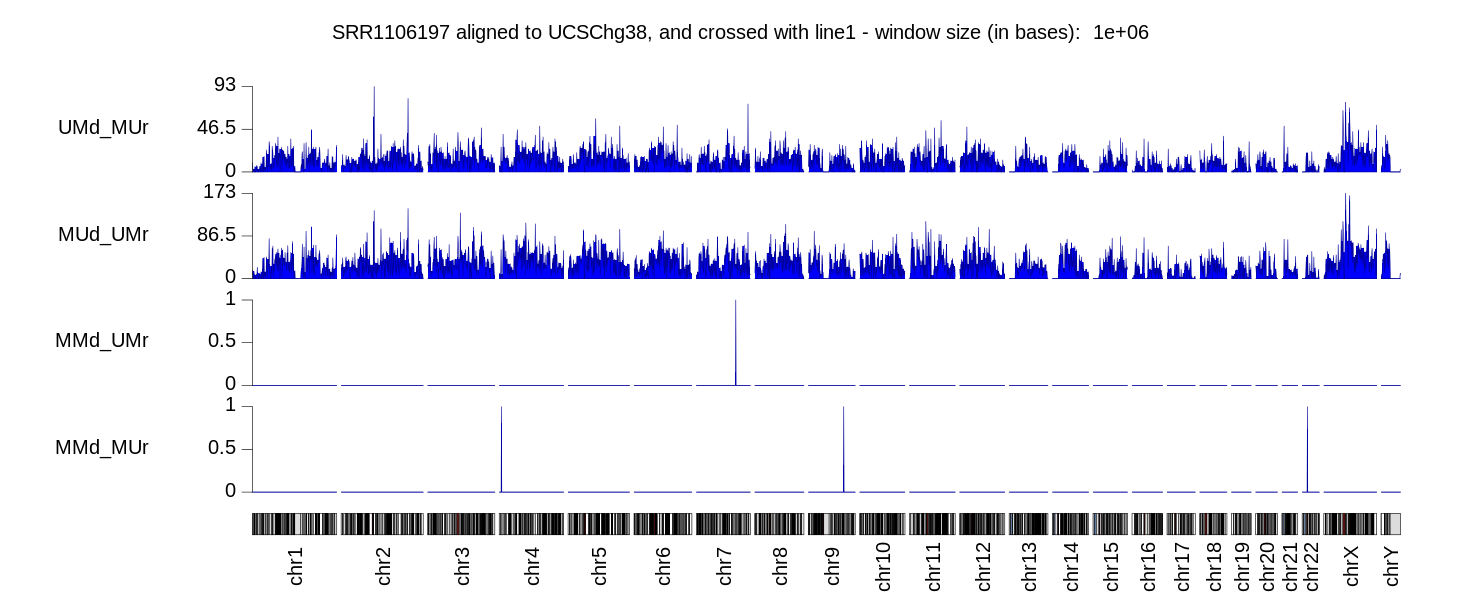

#### Crossings overlap graph - Putative insertion site

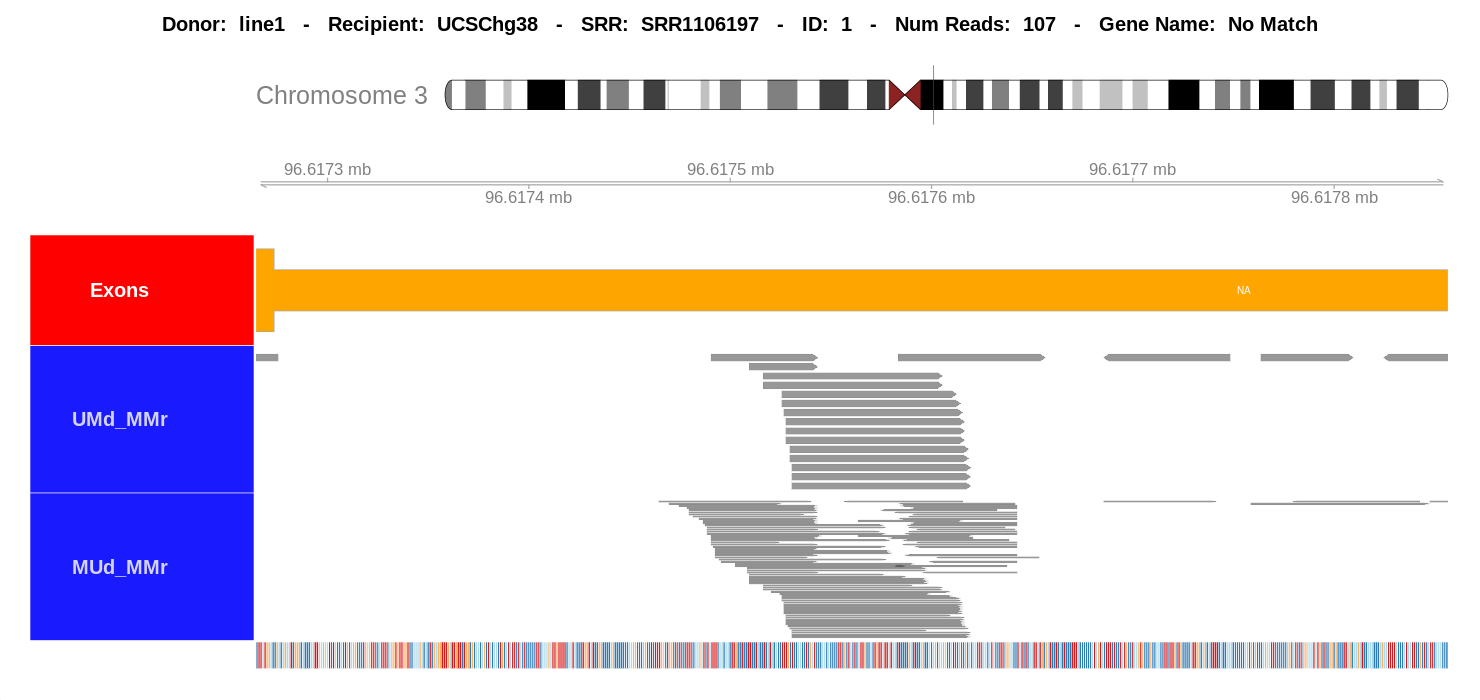

#### Crossings overlap graph - Putative insertion site

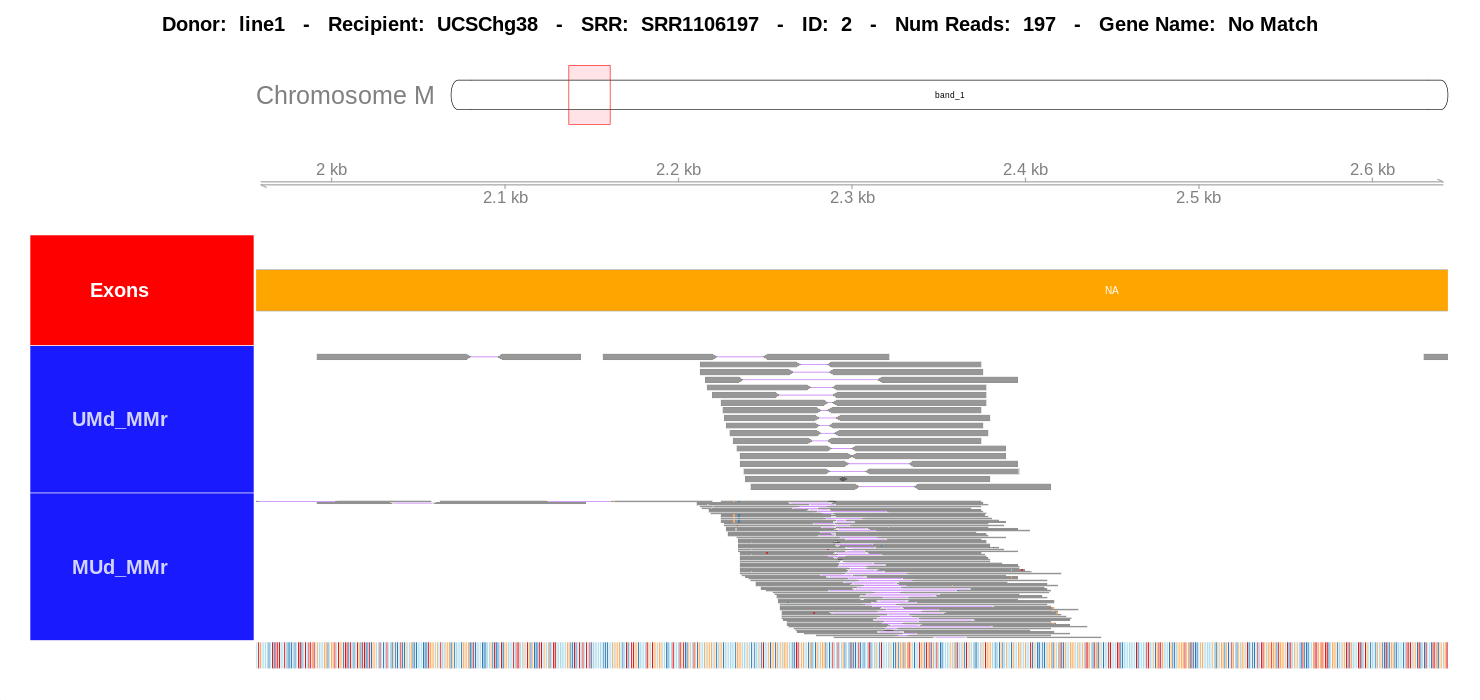

### SRR1106200

#### Donor reads density graph

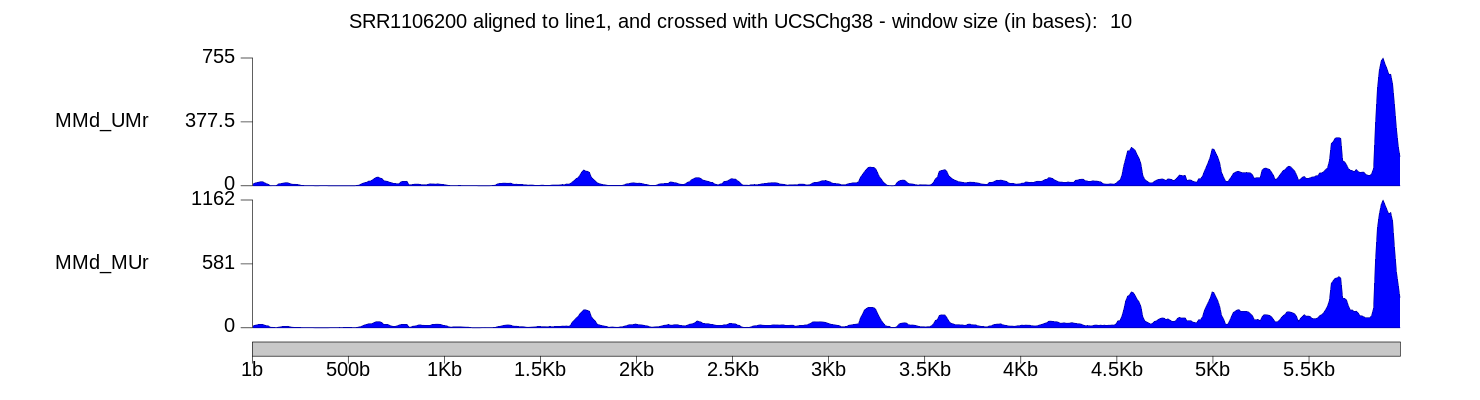

#### Recipient reads density graph

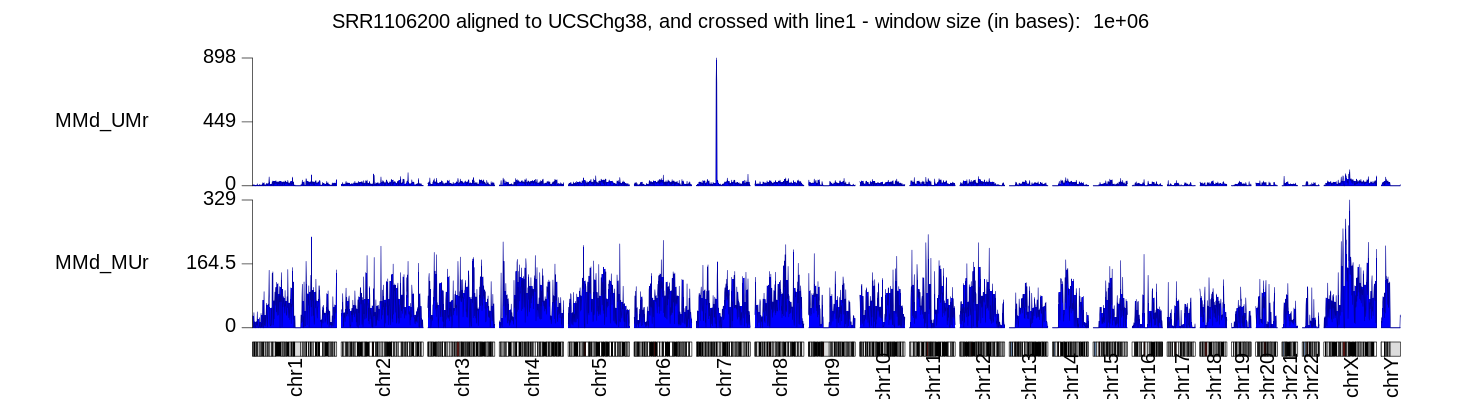

#### Crossings overlap graph - Putative insertion site

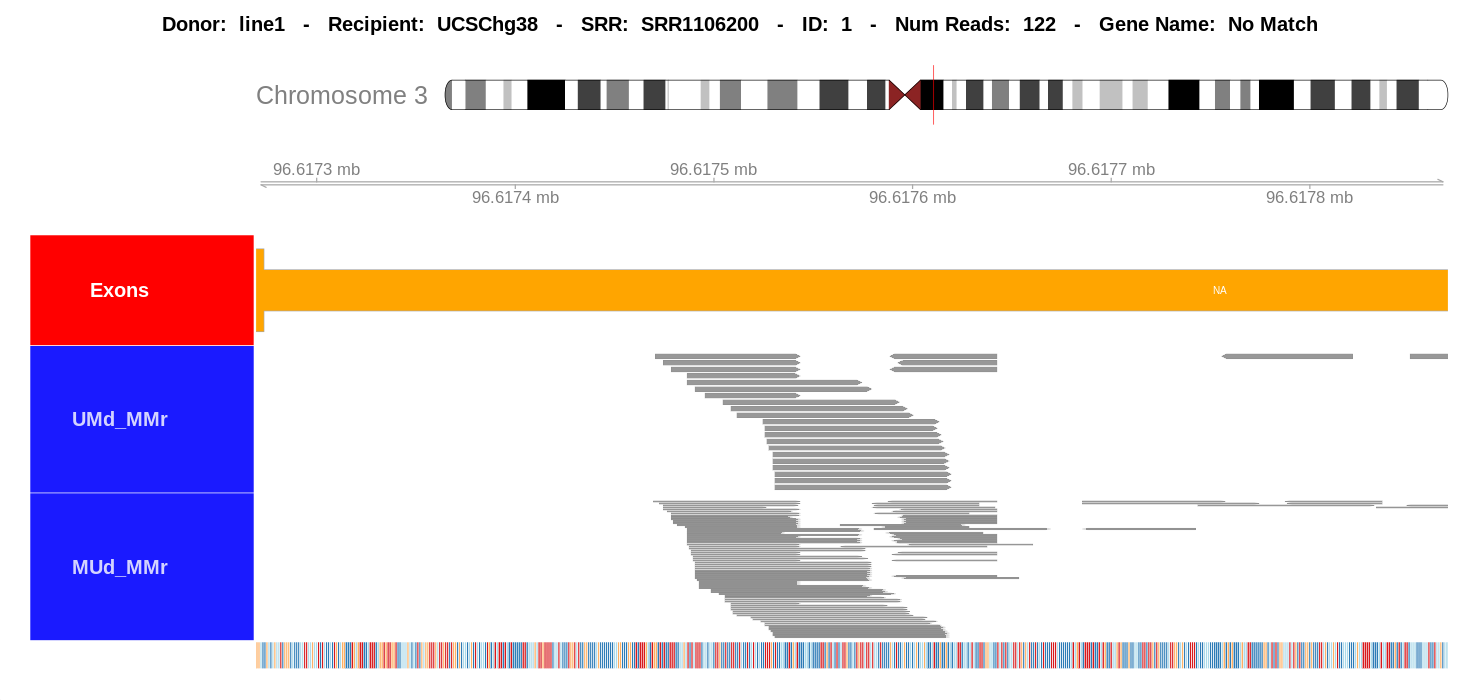

#### Crossings overlap graph - Putative insertion site

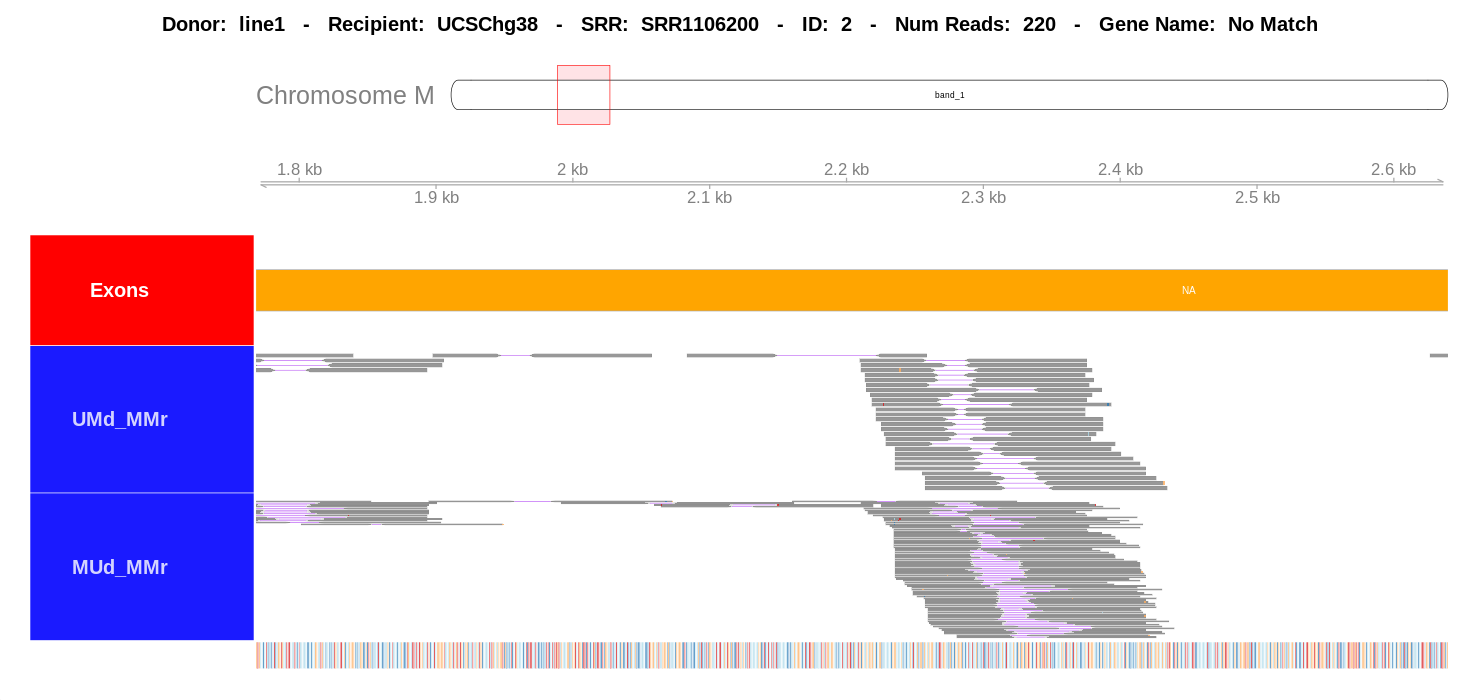

### SRR1106201

#### Donor reads density graph

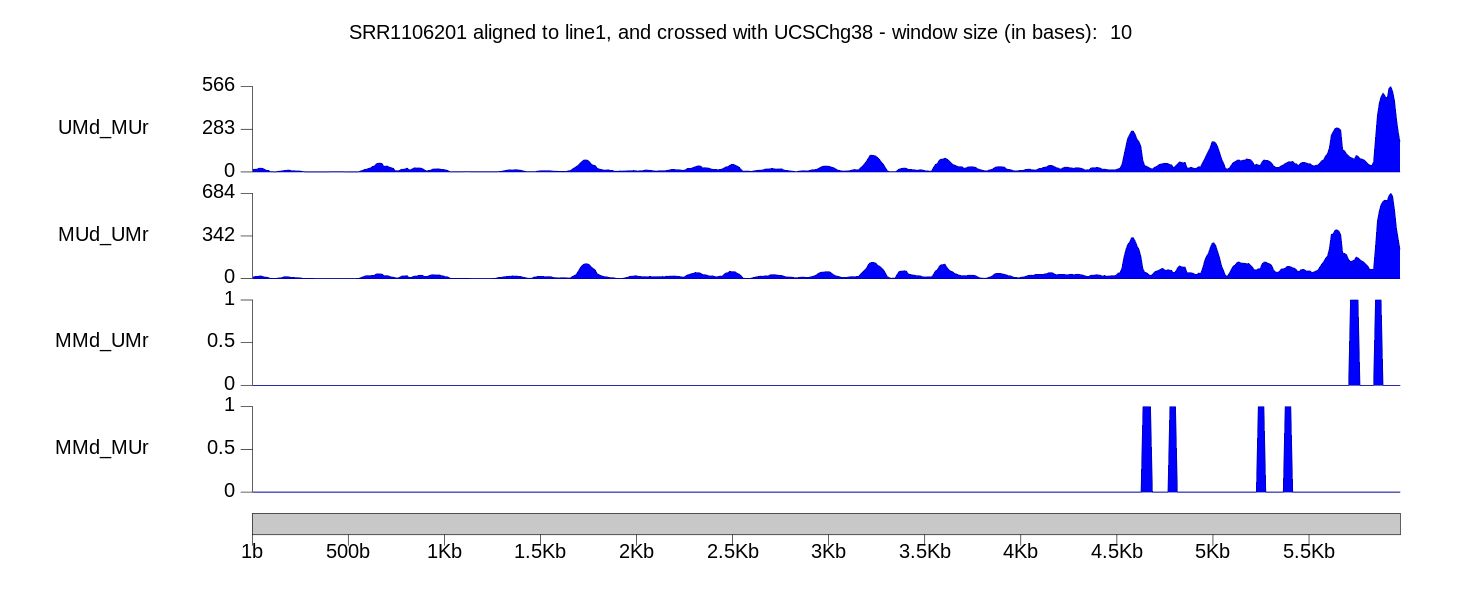

#### Recipient reads density graph

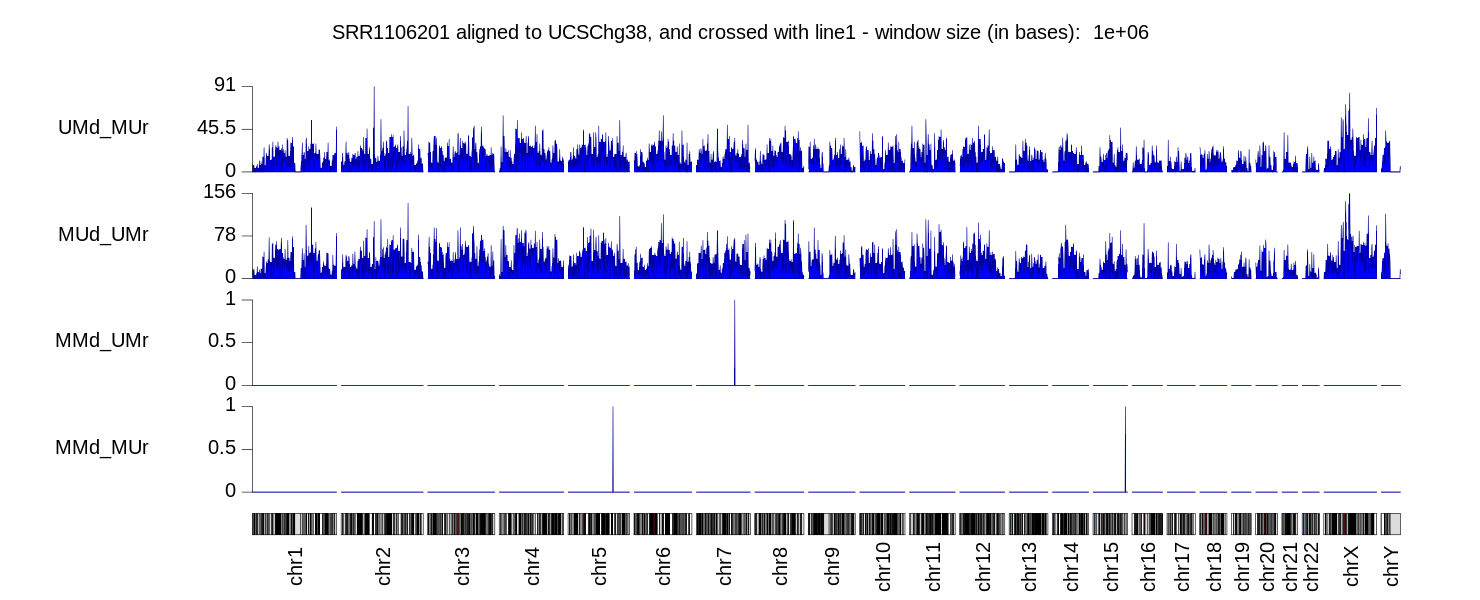

#### Crossings overlap graph - Putative insertion site

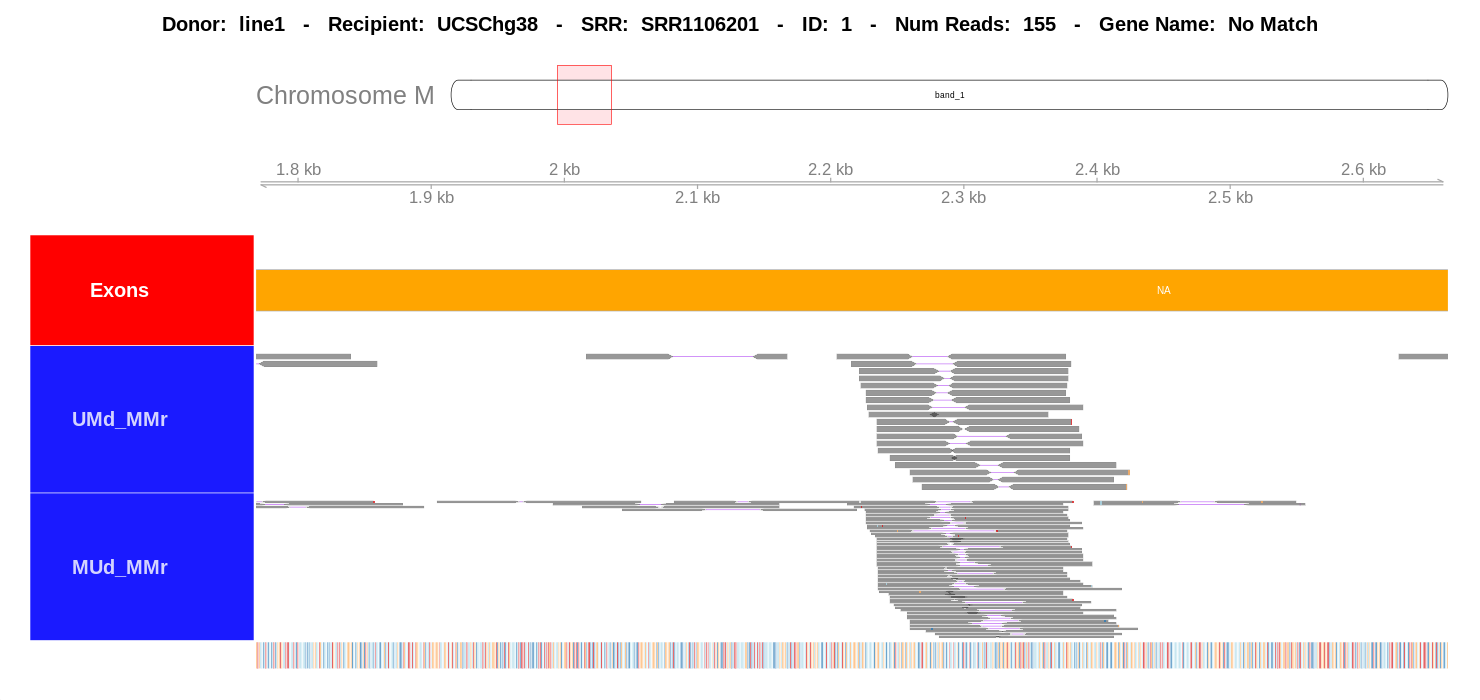

In [32]:
# Plot all the overlapping reads for all 'ids' for all 'srr's
plot_all_srrs(srr_names, srrs_summary_table, crossings, donor_granges_all_srrs, recip_granges_all_srrs, 
              recip_bams_all_srrs, donor_ref_genome, recipient_ref_genome, donor_name, recipient_name,
              extend_left = 100, extend_right = 100)